In [1]:
# default_exp standard_themes/saw

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Multilabel Classification - Standard S@W Themes

> Models to predict what standard themes a verbatim belongs too

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.16


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['question_report_abbr','answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '_qst_ans' # ''

Prepare the data source

In [11]:
train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

In [12]:
train_df.head()

,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,588941,1877,I enjoy our department potlucks and social activities. I am grateful that our department leader...,NaN,English,212,9,SAW,UCSD,449396,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,24000.0,3834,999999.0,UC San Diego,8000.0,MARINE SCIENCES,24000.0,DIRECTORS OFFICE-SIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,402308,1877,"UCSD needs to keep up with the modern workplace in order to get stronger, more competitive candi...",NaN,English,160,9,SAW,UCSD,272347,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,31404.0,3761,999999.0,UC San Diego,30000.0,Student Affairs,31400.0,Student Life,31404.0,Student Life Business Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,588571,1877,I do feel that some women are sometimes looked down upon by certain leadership individuals....fr...,NaN,English,212,9,SAW,UCSD,447748,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,91101.0,3667,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91100.0,OPHTHALMOLOGY,91101.0,BUSINESS OFFICE,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,588759,1877,In the last few years I have seen a downturn in the education we are providing the students. Thi...,NaN,English,212,9,SAW,UCSD,448522,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,90411.0,3308,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90100.0,MEDICAL EDUCATION,90410.0,UNDERGRADUATE MEDICAL EDUCATION (UGME),90411.0,UGME ADMINISTRATION & CURRICULUM,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,402941,1877,I came to UCSD with the purpose of growth. In my department the chances of growing is very minim...,NaN,English,160,9,SAW,UCSD,275202,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201,Comments re Work Environment at UCSD,Other,None,None,None,1,99134.0,4073,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOO

In [13]:
train_df.survey_id.value_counts()

212    1635
160     909
396     304
398     284
401      12
Name: survey_id, dtype: int64

Remove any rows whre the "corpus_cols" are nan

In [14]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [15]:
STANDARD_THEME_SAW_LABELS

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions',
 'career_advancement',
 'committed_to_diversity',
 'communicates_essential_information',
 'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
 'evaluated_fairly',
 'experienced_discrimination',
 'facilities_workspace_safety',
 'faculty_value_contributions',
 'favoritism_cliques',
 'fear_of_retaliation_negative_consequences',
 'feel_valued_by_department',
 'flexibility_work_life_balance',
 'good_use_of_skills',
 'have_necessary_tools',
 'have_voice_within_my_institution_valued_member_of_my_institution',
 'internal_processes_effective',
 'parking_transportation',
 'salary_pay',
 'satisfied_with_diversity_progams',
 'supervisor_effectiveness_resolves_staff_issues']

In [16]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_SAW_LABELS].head()

,labels,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,committed_to_diversity feel_valued_by_department satisfied_with_diversity_progams,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,have_voice_within_my_institution_valued_member_of_my_institution,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,ethical_conduct_perform_responsibilities_spirit_of_cooperation experienced_discrimination,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,adequate_staffing salary_pay,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,appropriate_stress_work_assigned_equitably faculty_value_contributions,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [18]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the low-level `Datasets` API

In [19]:
%%time

x_tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(vocab=vocab)
]

y_tfms = [ 
    ColReader(STANDARD_THEME_SAW_LABELS),
    EncodedMultiCategorize(vocab=STANDARD_THEME_SAW_LABELS),
]

dsets = Datasets(items=df,
                 tfms=[x_tfms, y_tfms], 
                 splits=ColSplitter(col='is_valid')(df), 
                 dl_type=SortedDL)

len(dsets.train), len(dsets.valid)

CPU times: user 368 ms, sys: 218 ms, total: 586 ms
Wall time: 915 ms


(3144, 350)

In [20]:
%%time
dls = dsets.dataloaders(bs=bsz, seq_len=bptt, before_batch=pad_input_chunk)

CPU times: user 4.2 s, sys: 889 ms, total: 5.09 s
Wall time: 5.12 s


In [21]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (25 items)


In [22]:
print(dls.train_ds[21])

(TensorText([    2,     8,   779,   673,     8,    51,     8,   277,    32,     7,
          115,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,   

In [23]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology",advancement_and_training_opportunities;committed_to_diversity;flexibility_work_life_balance;parking_transportation;salary_pay


In [24]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 477]) torch.cuda.LongTensor torch.Size([80, 25]) torch.cuda.FloatTensor 80


In [25]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotis

Using the mid-level `DataBlocks` API

In [26]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    MultiCategoryBlock(encoded=True, vocab=STANDARD_THEME_SAW_LABELS)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(STANDARD_THEME_SAW_LABELS),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 124 ms, sys: 3.83 ms, total: 128 ms
Wall time: 127 ms


In [27]:
# dblock.summary(df)

In [28]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 3.59 s, sys: 755 ms, total: 4.34 s
Wall time: 5.07 s


In [29]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (25 items)


In [30]:
print(dls.train_ds[21])

(TensorText([    2,     8,   779,   673,     8,    51,     8,   277,    32,     7,
          115,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,   

In [31]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology",advancement_and_training_opportunities;committed_to_diversity;flexibility_work_life_balance;parking_transportation;salary_pay


In [32]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 477]) torch.cuda.LongTensor torch.Size([80, 25]) torch.cuda.FloatTensor 80


In [33]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotis

Save the `Dataloaders` object for future use

In [34]:
# save dataloaders
torch.save(dls, STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')
# dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

## Training

Configure a forward or backwards run

In [35]:
backwards = False
m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))
#     dls.before_batch = partial(pad_input_chunk, pad_first=not backwards)

In [36]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'}  

Configure our metrics

In [37]:
# define metrics
beta, start, end, average, sample_weight = .5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
ap_score_metric = APScoreBinary(average=average, sample_weight=sample_weight)
bal_acc_metric = BalancedAccuracy(sample_weight=sample_weight)

Configure our loss

In [38]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [39]:
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))

Configure learner

In [40]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='fbeta_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [41]:
learn_cbs = []
fit_cbs = [best_model_cb, opt_thresh_cb]

learn_metrics = [ 
    accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric
]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.7,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
#                                 loss_func=loss_func,
                                cbs=learn_cbs,
                                path=STANDARD_THEME_SAW_PATH)

learn.opt = learn.create_opt()

In [42]:
# learn.summary()

In [43]:
# learn.show_training_loop()

In [44]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [45]:
best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

(0.13182567358016967, 0.04786301031708717)

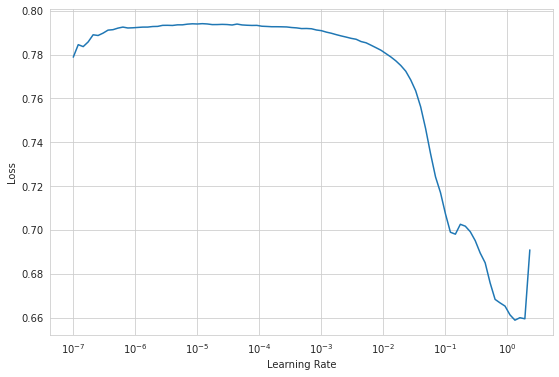

In [46]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [47]:
lr= lr_min

In [48]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.361494,0.228269,0.722971,0.162350,0.159600,0.523397,0.556667,0.090000,00:06


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.16235008025699468.


In [49]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last_ft_multilabel.pth')

In [50]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.241207,0.210209,0.892800,0.238423,0.262714,0.322357,0.612872,0.180000,00:06


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.23842308836392334.


In [51]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last2_ft_multilabel.pth')

In [52]:
learn.freeze_to(-3)
lr = lr/3
learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.212346,0.193129,0.918286,0.326901,0.387473,0.305026,0.623799,0.260000,00:09


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.32690103208357874.


In [53]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last3_ft_multilabel.pth')

In [54]:
learn.unfreeze()
lr = lr/10
learn.fit_one_cycle(20, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.194360,0.191531,0.917029,0.338219,0.387711,0.331023,0.634133,0.260000,00:10
1,0.194890,0.189482,0.924457,0.348790,0.421358,0.291161,0.623488,0.310000,00:10
2,0.192691,0.186585,0.920800,0.373730,0.411367,0.367418,0.655434,0.290000,00:10
3,0.187164,0.183081,0.920457,0.368833,0.411581,0.355286,0.649429,0.250000,00:10
4,0.183508,0.181413,0.920457,0.364665,0.384043,0.362218,0.653500,0.270000,00:10
5,0.179850,0.179600,0.922971,0.376412,0.406125,0.344887,0.647862,0.290000,00:10
6,0.176180,0.178420,0.925943,0.387378,0.425281,0.327556,0.642528,0.320000,00:10
7,0.173243,0.177444,0.929143,0.418186,0.472237,0.331023,0.646697,0.360000,00:10
8,0.166798,0.176305,0.933943,0.415199,0.514820,0.277296,0.625810,0.400000,00:10
9,0.163790,0.177695,0.933943,0.418730,0.503123,0.282496,0.627695,0.400000,00:10


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with fbeta_score value: 0.33821945844623696.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with fbeta_score value: 0.34879049017661856.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with fbeta_score value: 0.3737303353251664.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 5 with fbeta_score value: 0.3764118364867769.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 6 with fbeta_score value: 0.38737849118162504.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with fbeta_score value: 0.4181857846782636.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 9 with fbeta_score value: 0.4187302269332854.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 10 with fbeta_score value: 0.4266109282811045.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Better model found at epoch 14 with fbeta_score value: 0.4298855587637329.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 15 with fbeta_score value: 0.4417081347084808.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [55]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above)

0.4699999999999998

In [56]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_multilabel.pth')

Export model for inference

In [57]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [58]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [59]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'valid_loss': 0.18064944446086884,
 'accuracy_multi': 0.9350857734680176,
 'fbeta_score': 0.433901555608735,
 'precision_score': 0.5249173514765589,
 'recall_score': 0.292894280762565,
 'roc_auc_score': 0.6339697729071002,
 'opt_th': 0.4699999999999998}

In [60]:
#learn.show_results(max_n=4, trunc_at=60) #=> throws an exception right now!!!

In [72]:
interp = Interpretation.from_learner(learn)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
interp.plot_top_losses(k=5)

,input,target,predicted,probability,loss
0,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj comments re xxmaj work,advancement_and_training_opportunities;committed_to_diversity;feel_valued_by_department;flexibility_work_life_balance;have_voice_within_my_institution_valued_member_of_my_institution,appropriate_stress_work_assigned_equitably;career_advancement,0.635554850101471,0.8492529988288879
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj comments re xxmaj work,advancement_and_training_opportunities;benefits;career_advancement;evaluated_fairly;favoritism_cliques;salary_pay,salary_pay,0.7248741984367371,0.6963560581207275
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj comments re xxmaj work xxmaj environment at xxup ucsd xxmaj it should be noted that several staff members have been subject to bullying in the department . i have also seen women whose careers have been negatively impacted by the decision to have children . xxmaj one new mother left the university last year because management would not work with her on a flexible / part time work schedule . xxmaj another pregnant staff member recently,adequate_staffing;appropriate_stress_work_assigned_equitably;ethical_conduct_perform_responsibilities_spirit_of_cooperation;experienced_discrimination;fear_of_retaliation_negative_consequences;flexibility_work_life_balance,appropriate_stress_work_assigned_equitably,0.5520105361938477,0.6150082945823669
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad

Use it for inference

In [74]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [75]:
inf_learn.loss_func.thresh

0.4699999999999998

In [76]:
inf_learn.predict('We are not paid enough. Faculty do not value us and the benefits are horrible and we need more staff', 
                  with_input=True)

('xxbos xxmaj we are not paid enough . xxmaj faculty do not value us and the benefits are horrible and we need more staff',
 (#3) ['fear_of_retaliation_negative_consequences','feel_valued_by_department','salary_pay'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True,  True, False, False, False, False,
         False, False,  True, False, False]),
 tensor([3.9375e-01, 2.5143e-03, 2.0006e-02, 4.3959e-01, 6.7843e-03, 8.0514e-03,
         1.0944e-01, 1.5321e-04, 5.7064e-02, 4.2495e-04, 2.6013e-05, 4.7539e-03,
         1.9562e-01, 1.3676e-05, 5.9312e-01, 5.8623e-01, 4.6470e-01, 3.8968e-03,
         7.6013e-04, 1.2549e-02, 3.3916e-04, 3.8986e-01, 8.8672e-01, 3.0656e-02,
         4.2527e-02]))

Review final validation loss for best model

In [77]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [78]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [79]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.18064944446086884


In [80]:
learn.predict("The faculty really support us well!!!  It's great working and I feel valued")

((#2) ['faculty_value_contributions','feel_valued_by_department'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False,  True, False, False, False, False,
         False, False, False, False, False]),
 tensor([9.1363e-04, 4.3279e-04, 4.1893e-03, 3.0414e-06, 2.0088e-02, 2.0982e-03,
         4.4710e-04, 5.5238e-05, 1.0031e-01, 1.4928e-06, 5.1524e-03, 4.5609e-05,
         8.4233e-01, 6.4992e-06, 2.5838e-03, 6.0599e-01, 1.4997e-04, 2.3416e-03,
         3.8993e-07, 1.2805e-02, 6.2581e-05, 6.0450e-08, 1.7477e-04, 7.9243e-03,
         5.7387e-03]))

## Review

### Lets look at validation metrics

In [81]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs  = learn.get_preds(with_input=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(350,
 torch.Size([350, 25]),
 torch.Size([350, 25]),
 350,
 25,
 0.4699999999999998)

In [82]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [83]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.4600000000000001, 0.22000000000000003, 0.1)

In [84]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.4417081347084808, 0.4188552996025016, 0.5262617041458072)

In [85]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=.5, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.4417081347084808

In [86]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9350857138633728, 0.9066285490989685, 0.8551999926567078)

In [87]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9350857138633728

### Overall metrics

In [88]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [89]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.26


In [90]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9350857142857143


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [91]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 8173


In [92]:
most_freq_class_count / len(eval_targs)

0.9340571428571428

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [93]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.34939008920817505


#### Confusion Matrix

Describes the performance of a classification model

In [94]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [95]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

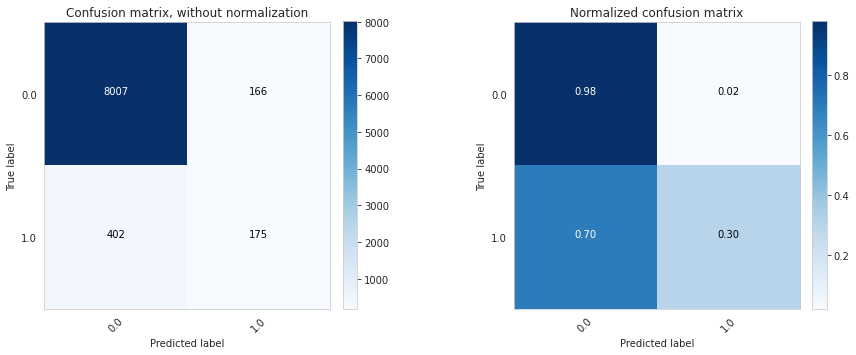

In [96]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [97]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

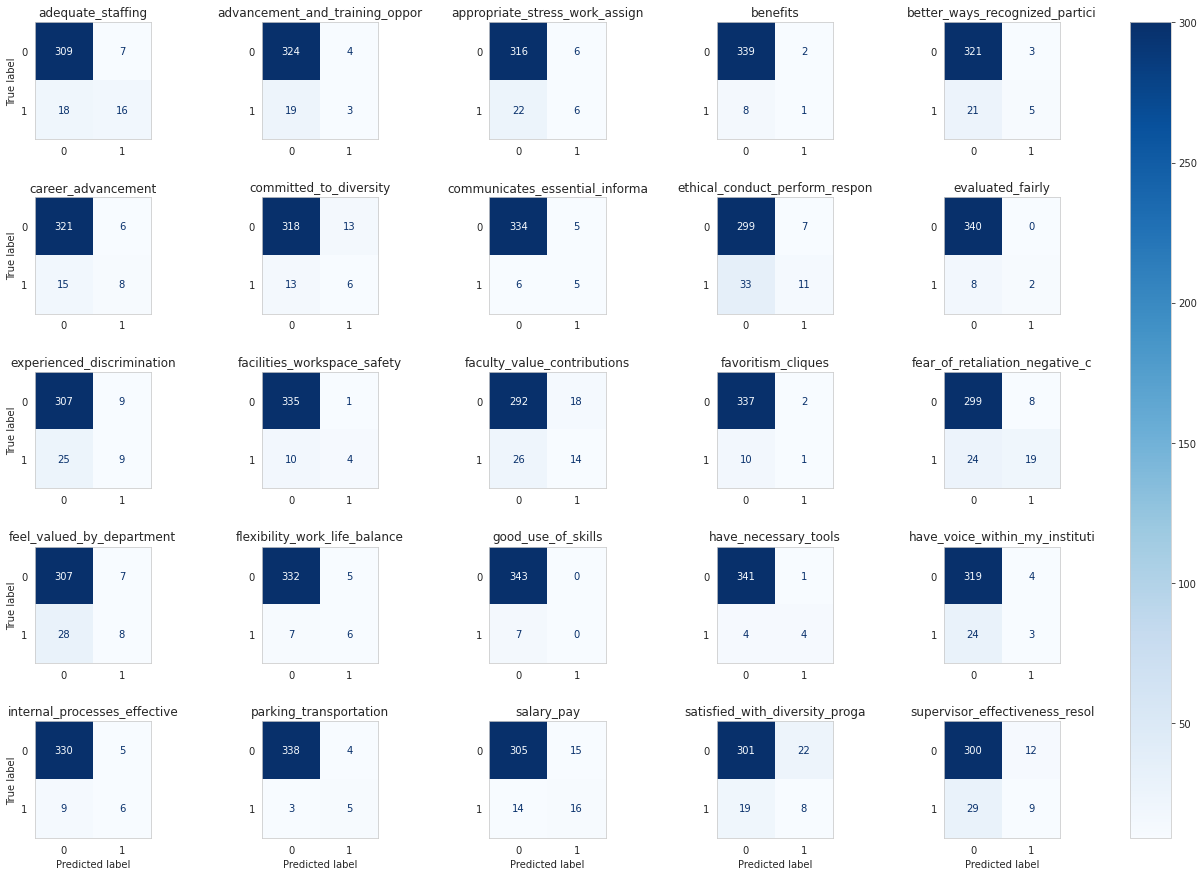

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(5, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(25):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_SAW_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.5)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [99]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8173
           1       0.51      0.30      0.38       577

    accuracy                           0.94      8750
   macro avg       0.73      0.64      0.67      8750
weighted avg       0.92      0.94      0.93      8750



In [112]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_SAW_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
adequate_staffing,0.695652,0.470588,0.561404,34.0
advancement_and_training_opportunities,0.428571,0.136364,0.206897,22.0
appropriate_stress_work_assigned_equitably,0.500000,0.214286,0.300000,28.0
benefits,0.333333,0.111111,0.166667,9.0
better_ways_recognized_participate_in_decisions,0.625000,0.192308,0.294118,26.0
career_advancement,0.571429,0.347826,0.432432,23.0
committed_to_diversity,0.315789,0.315789,0.315789,19.0
communicates_essential_information,0.500000,0.454545,0.476190,11.0
ethical_conduct_perform_responsibilities_spirit_of_cooperation,0.611111,0.250000,0.354839,44.0
evaluated_fairly,1.000000,0.200000,0.333333,10.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

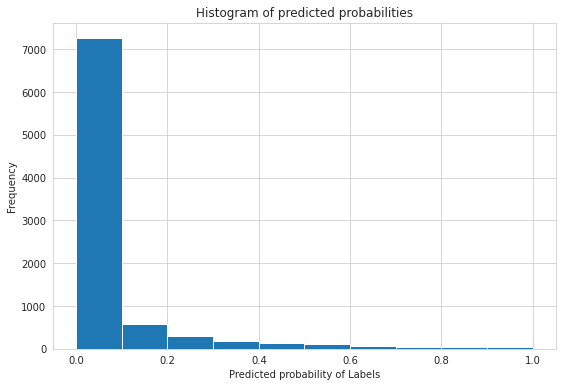

In [101]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [102]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

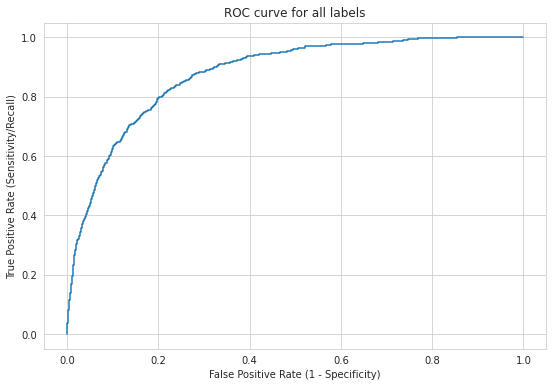

In [103]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [104]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.8773193469387408


### Let's look at things by label by label

In [105]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
# label_metrics

ADEQUATE_STAFFING

Null Accuracy:	0.9028571428571428
AUC Score:	0.8550819061801935

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9285714285714286	0.8942857142857142	0.8342857142857143	
Cohen's Kappa:	0.524094419667138	0.49646162221012524	0.3804931640625001	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.945               0.9778              0.9611              316                 
1                   0.6957              0.4706              0.5614              34                  
avg/total           0.8203              0.7242              0.7613              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9635              0.9177              0.94                316                 
1                   0.4694              0.6765              0.5542              

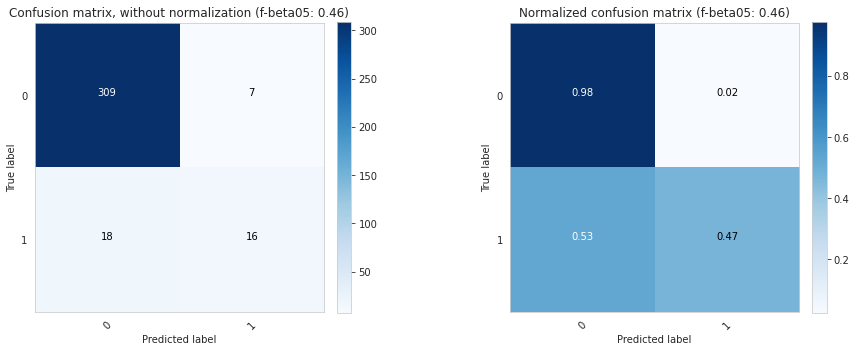

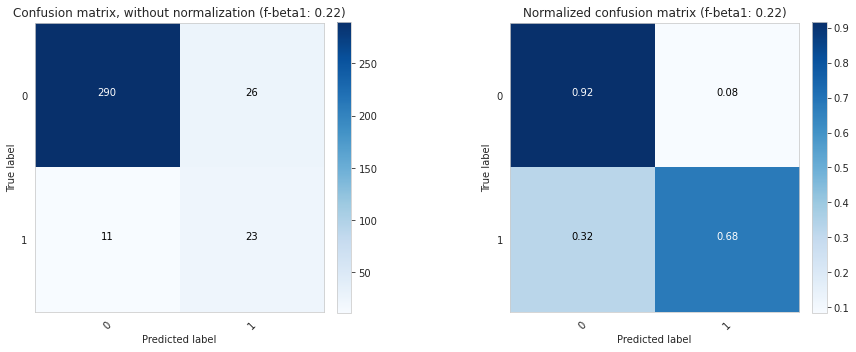

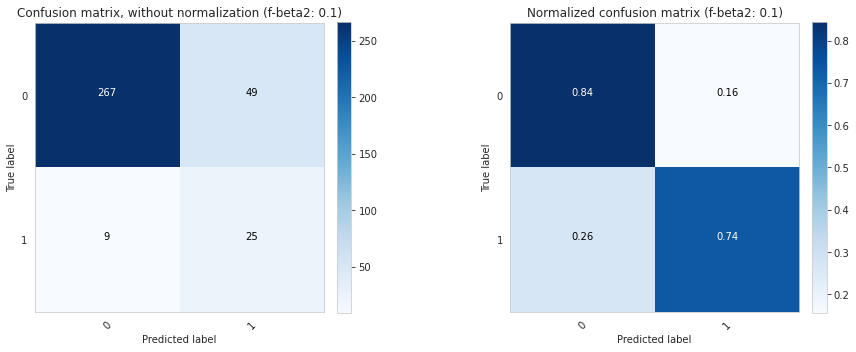



ROC Curve:


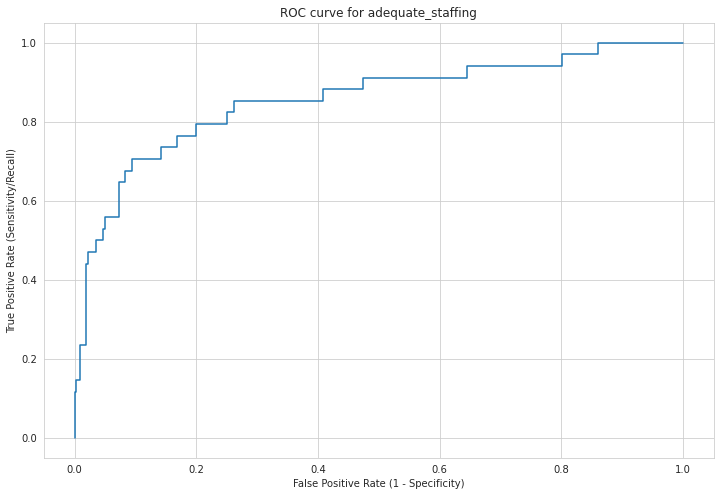

Predicted Probability Distribution:


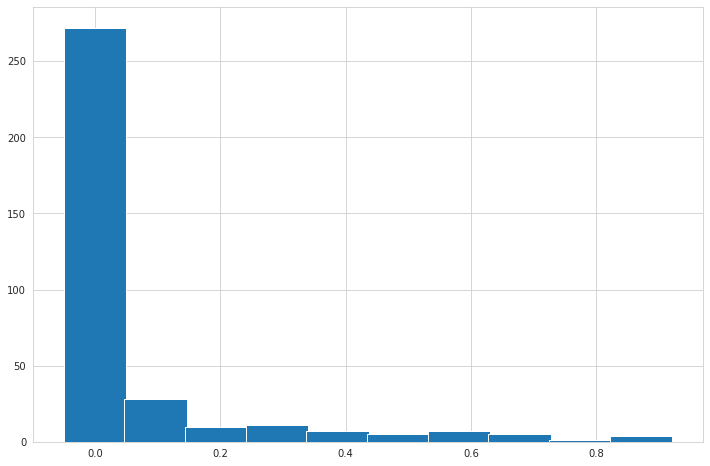



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9371428571428572
AUC Score:	0.8919068736141906

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9342857142857143	0.92	0.9	
Cohen's Kappa:	0.182076813655761	0.2908827785817656	0.37608230620352445	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9446              0.9878              0.9657              328                 
1                   0.4286              0.1364              0.2069              22                  
avg/total           0.6866              0.5621              0.5863              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9545              0.9604              0.9574              328 

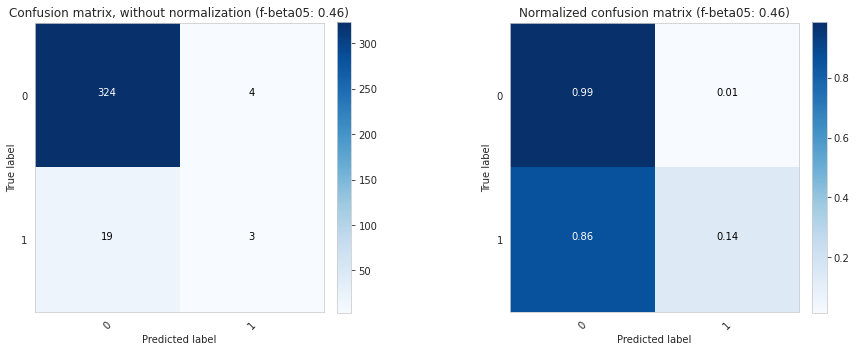

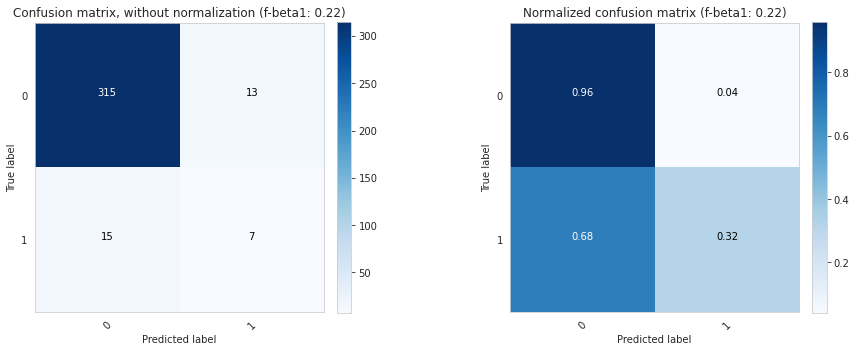

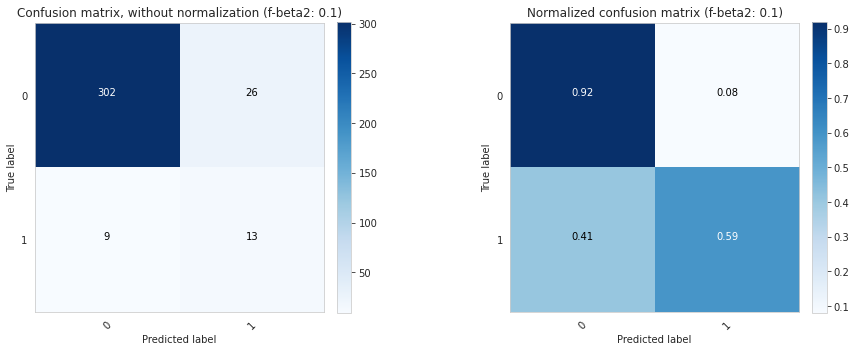



ROC Curve:


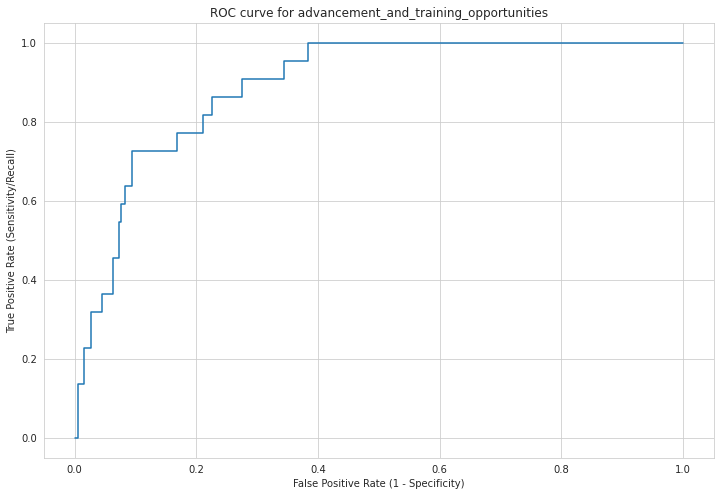

Predicted Probability Distribution:


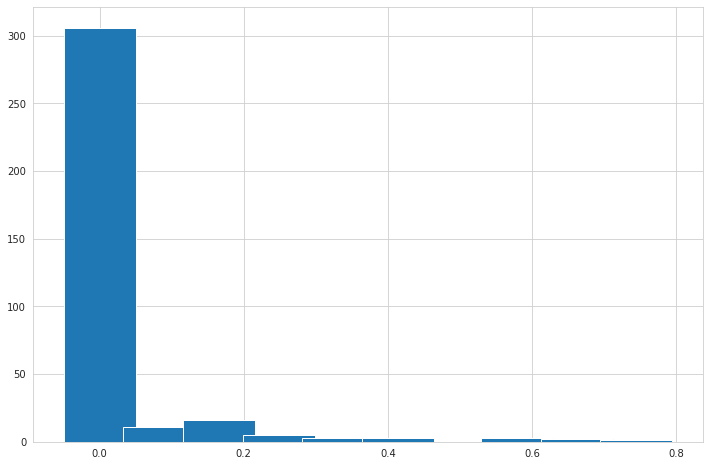



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.92
AUC Score:	0.8557009760425909

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.92	0.8771428571428571	0.7742857142857142	
Cohen's Kappa:	0.2647058823529411	0.2922975641869652	0.21844083893945399	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9349              0.9814              0.9576              322                 
1                   0.5                 0.2143              0.3                 28                  
avg/total           0.7175              0.5978              0.6288              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9486              0.9161              0.9321            

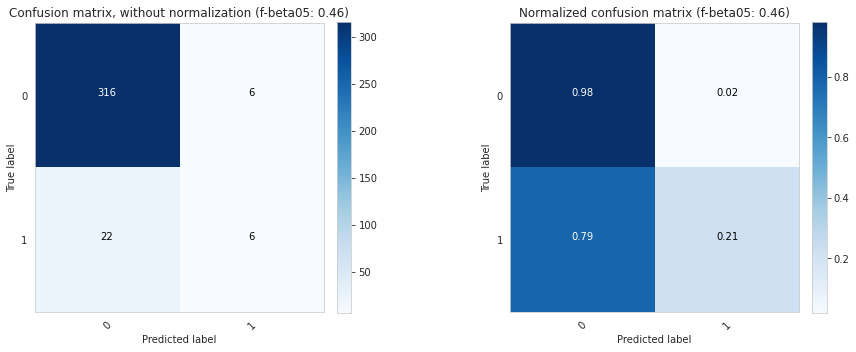

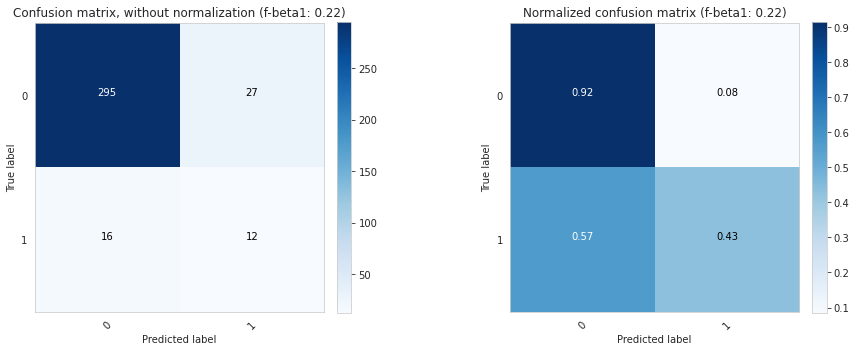

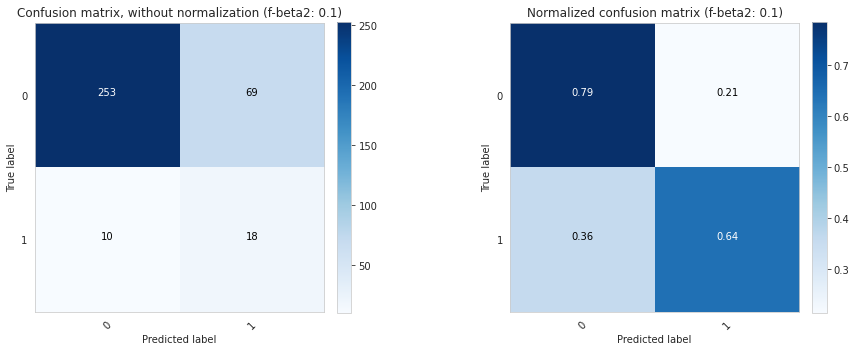



ROC Curve:


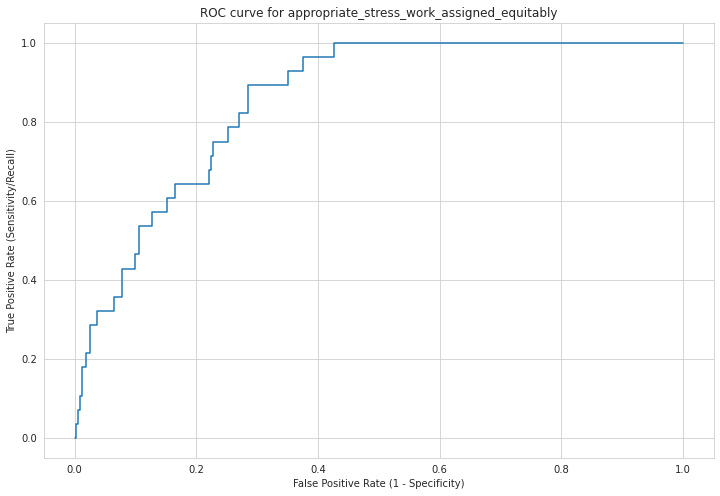

Predicted Probability Distribution:


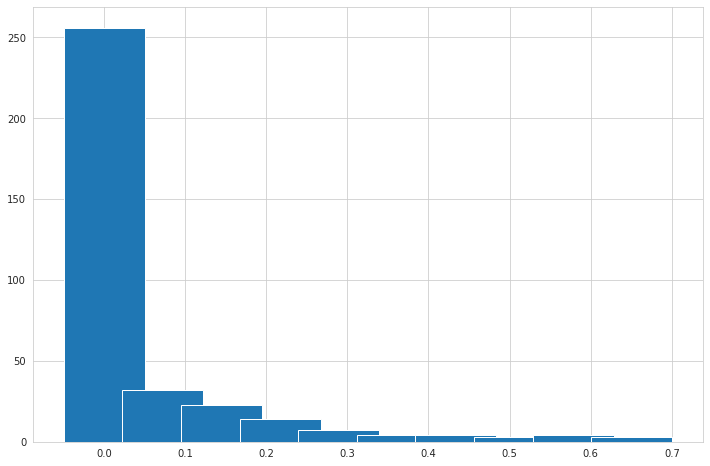



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9742857142857143
AUC Score:	0.9152818507657217

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9714285714285714	0.9742857142857143	0.9771428571428571	
Cohen's Kappa:	0.15581283164495907	0.29656096471639126	0.48849104859335035	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9769              0.9941              0.9855              341                 
1                   0.3333              0.1111              0.1667              9                   
avg/total           0.6551              0.5526              0.5761              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9798              0.9941              0.9869              34

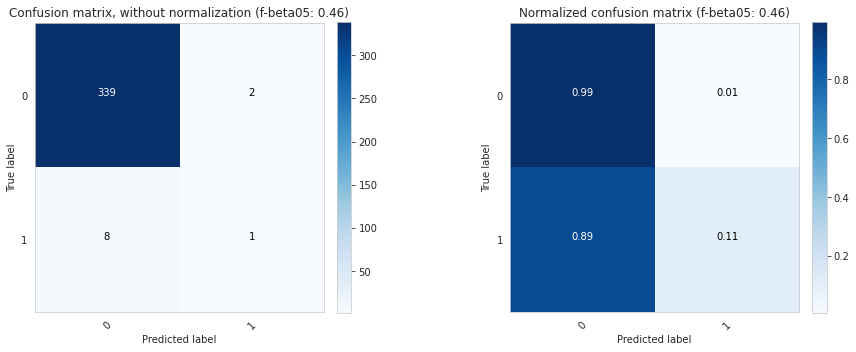

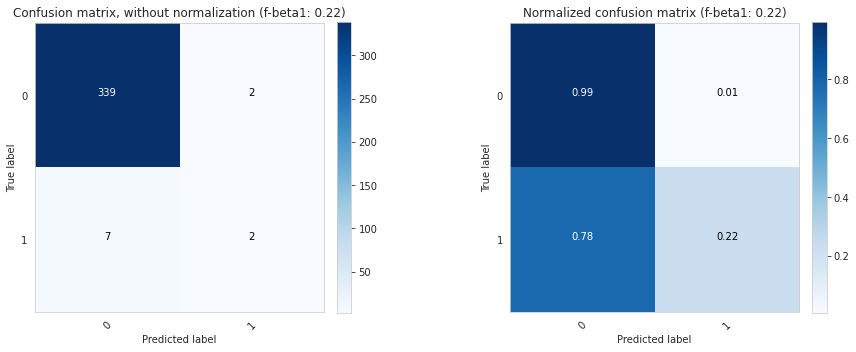

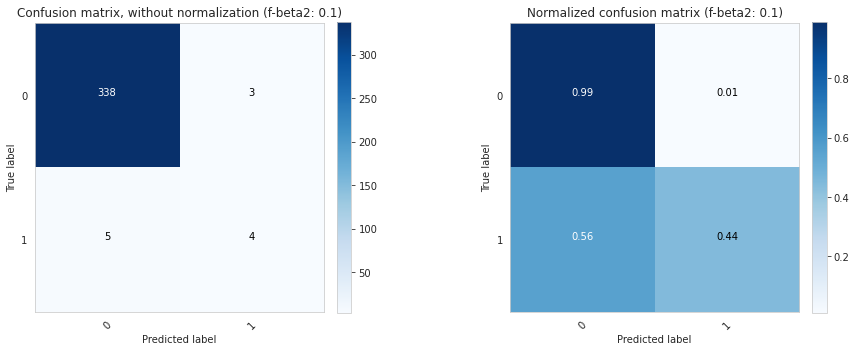



ROC Curve:


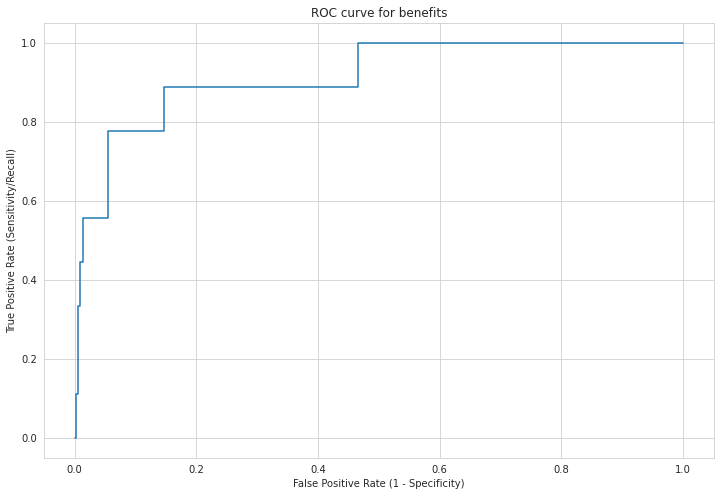

Predicted Probability Distribution:


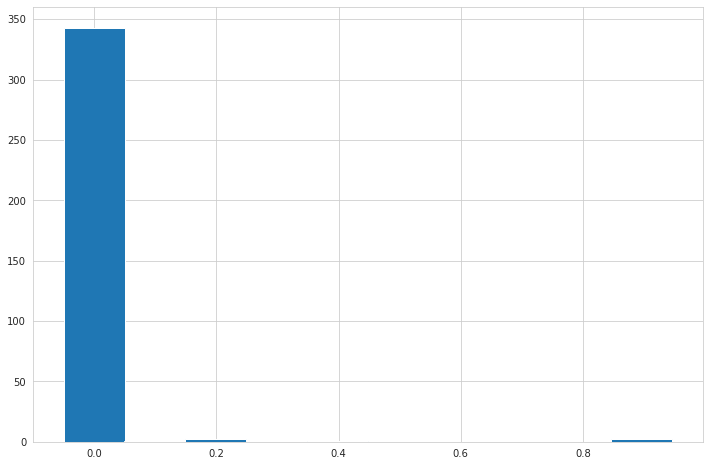



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.9257142857142857
AUC Score:	0.872269705603039

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9314285714285714	0.9142857142857143	0.8628571428571429	
Cohen's Kappa:	0.26854754440961337	0.417960088691796	0.36325045482110374	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9386              0.9907              0.964               324                 
1                   0.625               0.1923              0.2941              26                  
avg/total           0.7818              0.5915              0.629               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9594              0.9475

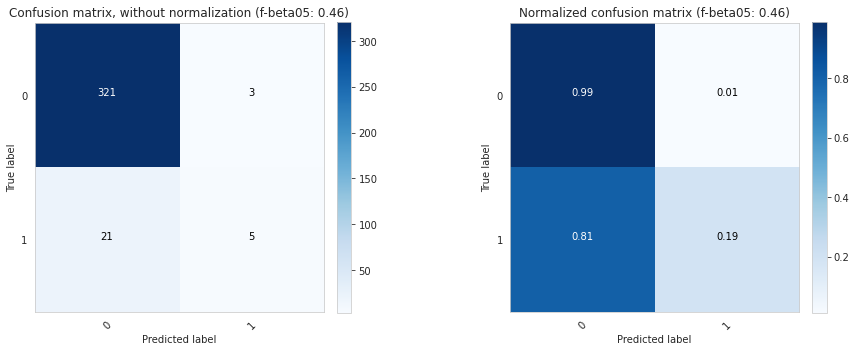

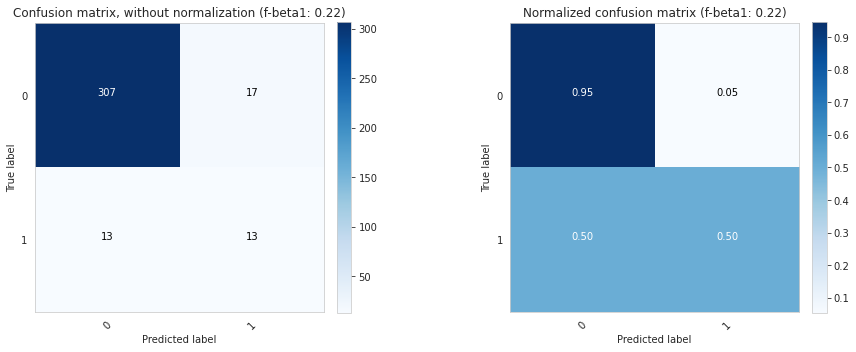

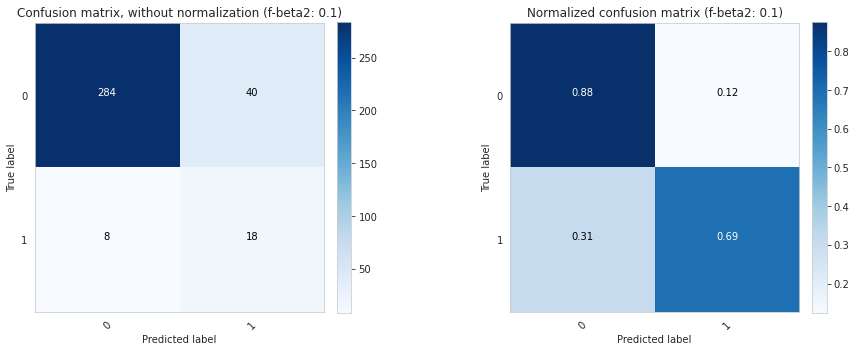



ROC Curve:


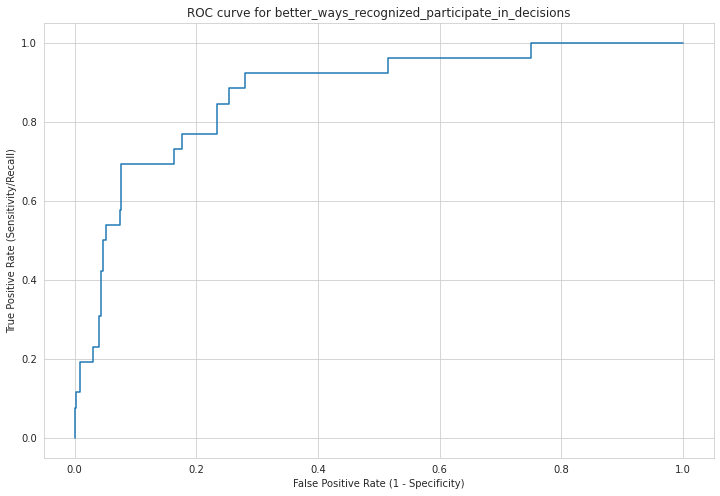

Predicted Probability Distribution:


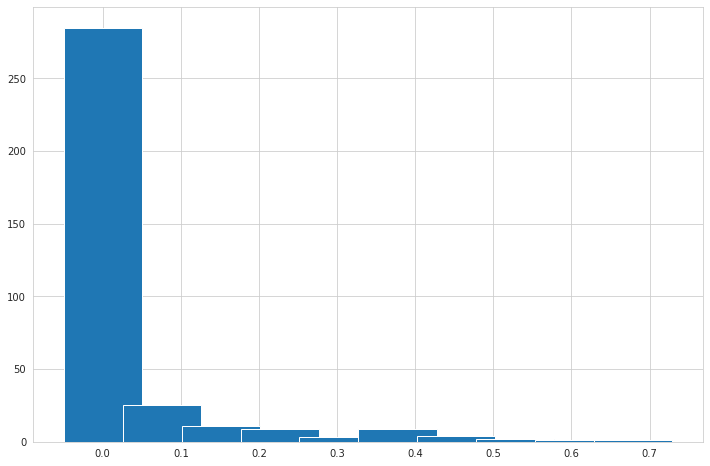



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.9342857142857143
AUC Score:	0.8796702566148118

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.94	0.9228571428571428	0.84	
Cohen's Kappa:	0.40273037542662116	0.5024744656207224	0.29521754764473207	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9554              0.9817              0.9683              327                 
1                   0.5714              0.3478              0.4324              23                  
avg/total           0.7634              0.6647              0.7004              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9777              0.9388              0.9579              327                 


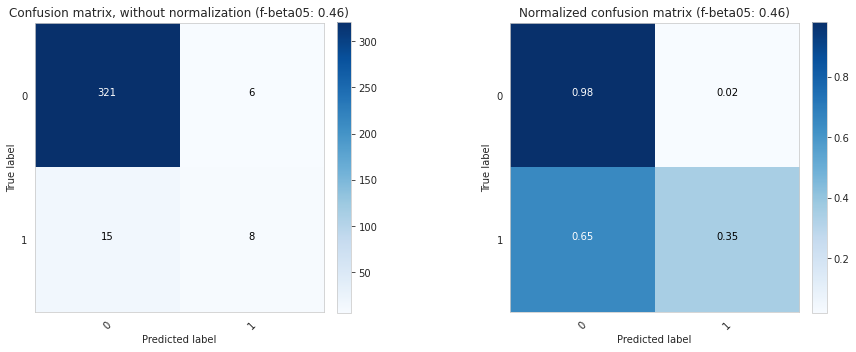

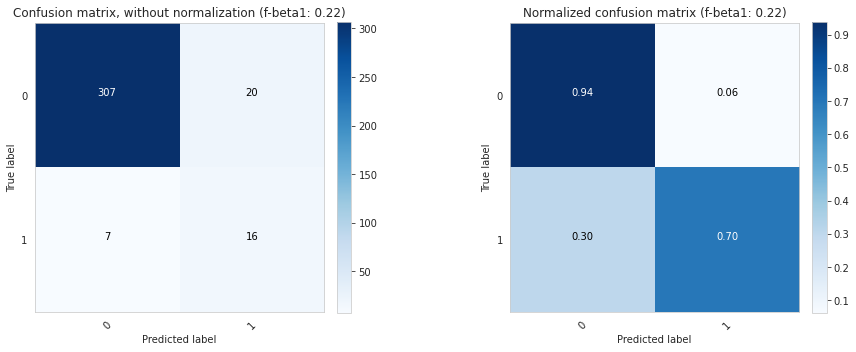

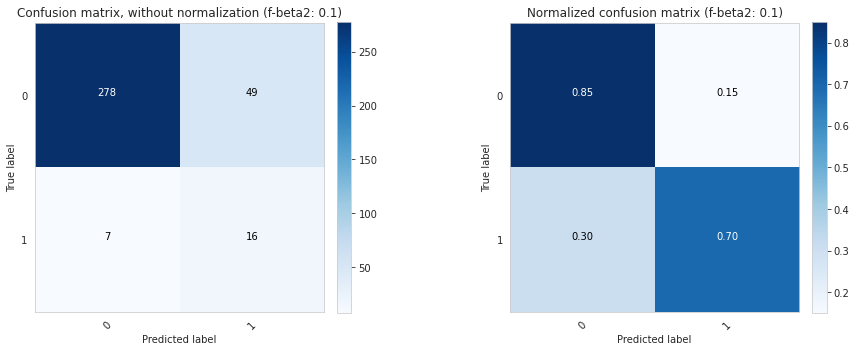



ROC Curve:


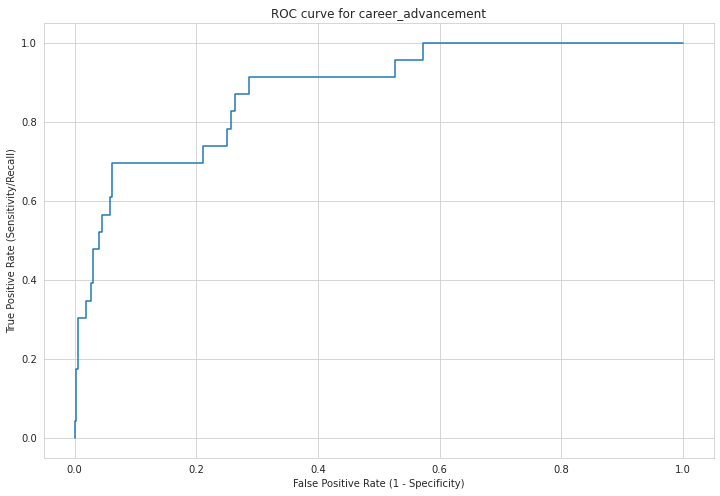

Predicted Probability Distribution:


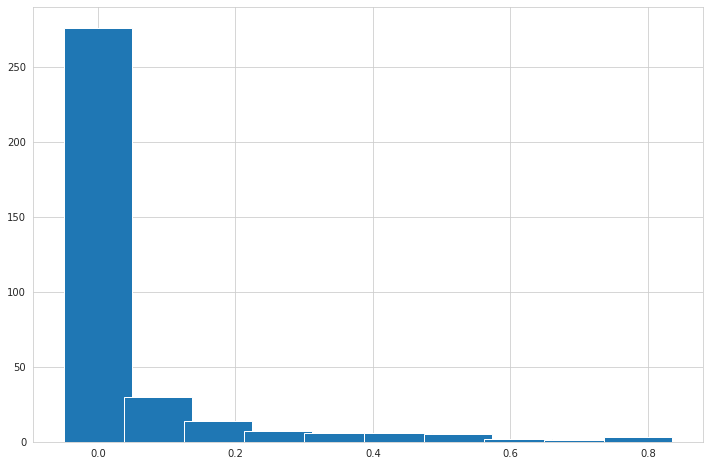



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9457142857142857
AUC Score:	0.8575290189219271

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9257142857142857	0.9114285714285715	0.8571428571428571	
Cohen's Kappa:	0.2765145492129115	0.41370366367664546	0.3185888949458765	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9607              0.9607              0.9607              331                 
1                   0.3158              0.3158              0.3158              19                  
avg/total           0.6383              0.6383              0.6383              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9808              0.9245              0.9518    

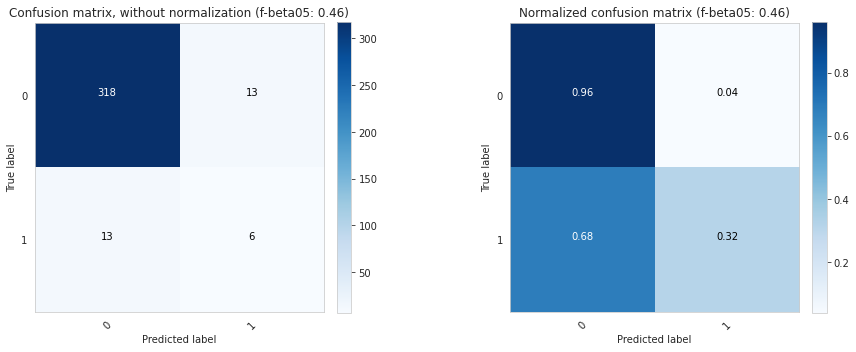

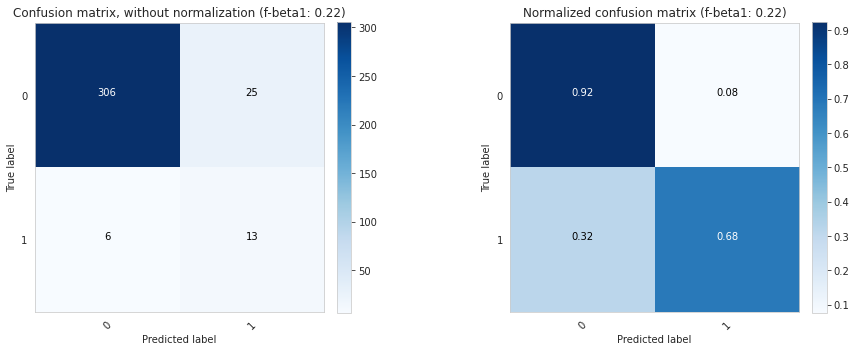

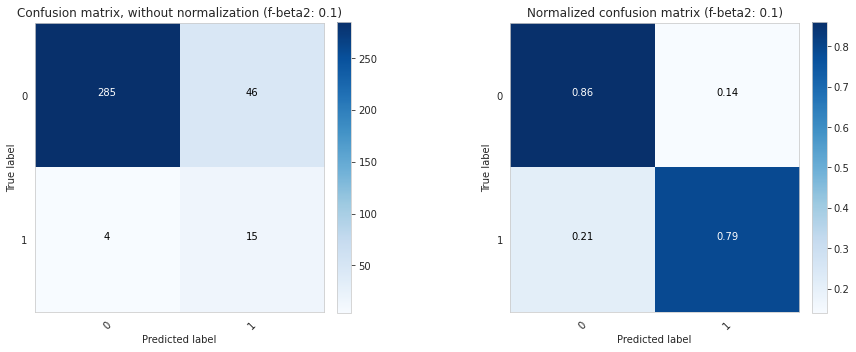



ROC Curve:


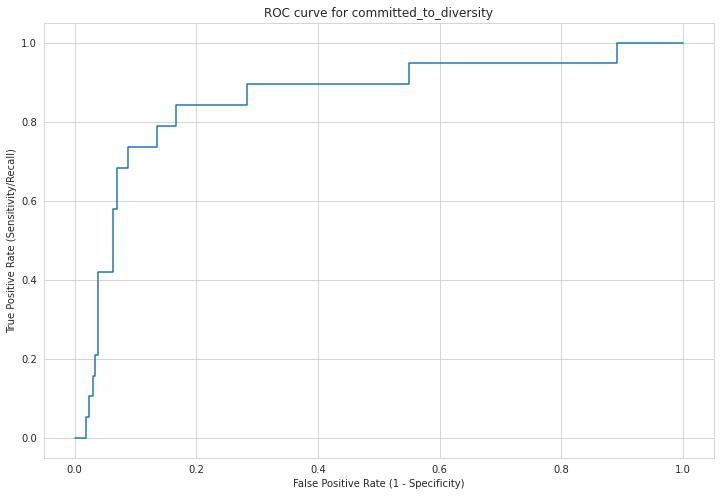

Predicted Probability Distribution:


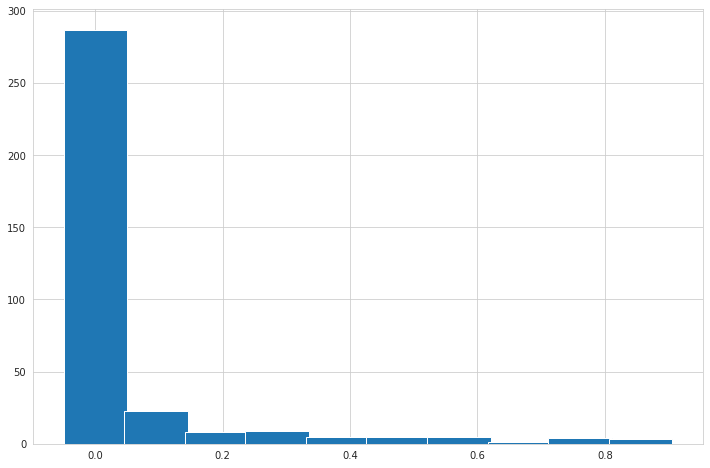



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9685714285714285
AUC Score:	0.9136497720568516

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9685714285714285	0.9485714285714286	0.9114285714285715	
Cohen's Kappa:	0.4600280504908836	0.37512398333663965	0.33492705651587595	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9824              0.9853              0.9838              339                 
1                   0.5                 0.4545              0.4762              11                  
avg/total           0.7412              0.7199              0.73                350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9849              0.9617           

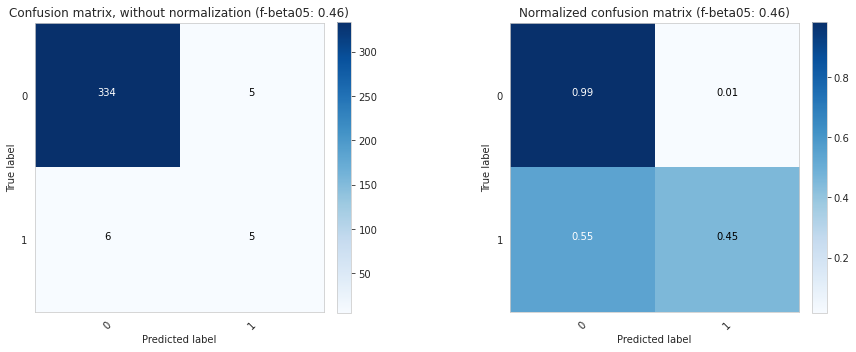

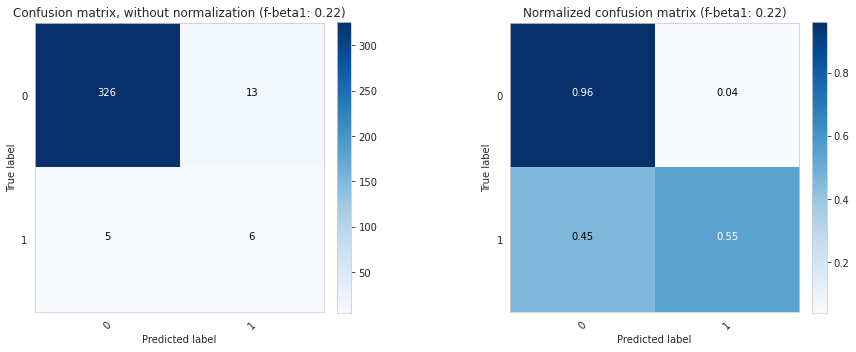

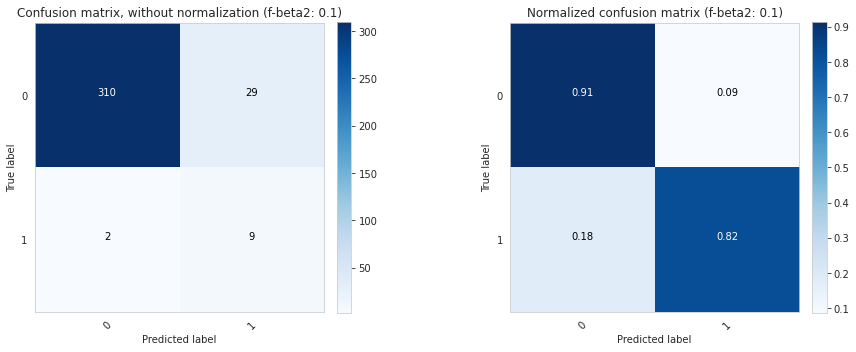



ROC Curve:


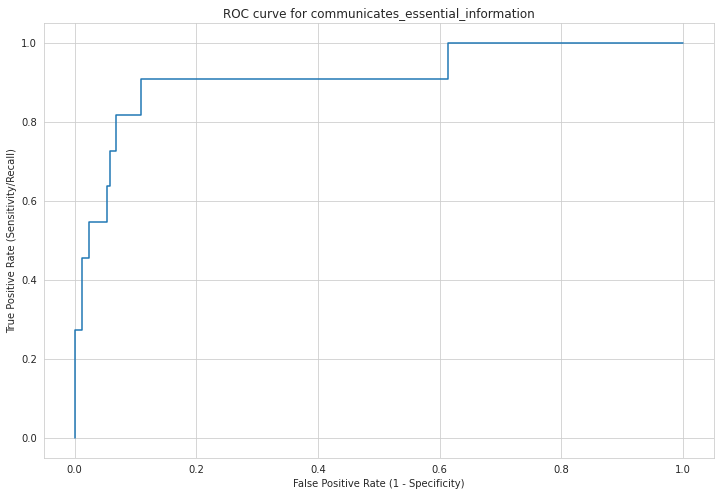

Predicted Probability Distribution:


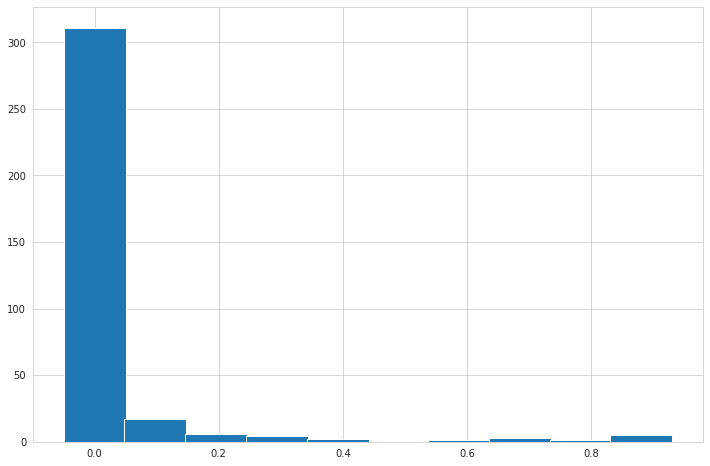



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.8742857142857143
AUC Score:	0.7849079025549615

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.8857142857142857	0.7542857142857143	0.6114285714285714	
Cohen's Kappa:	0.3040365877908132	0.248026381532927	0.19174081369286133	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9006              0.9771              0.9373              306                 
1                   0.6111              0.25                0.3548              44                  
avg/total           0.7559              0.6136              0.6461              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9297     

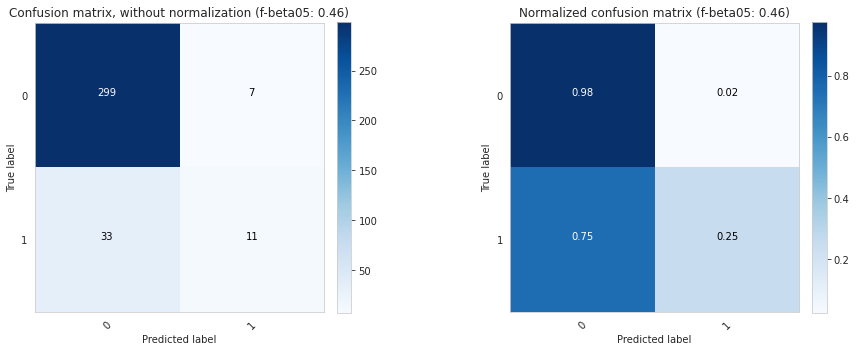

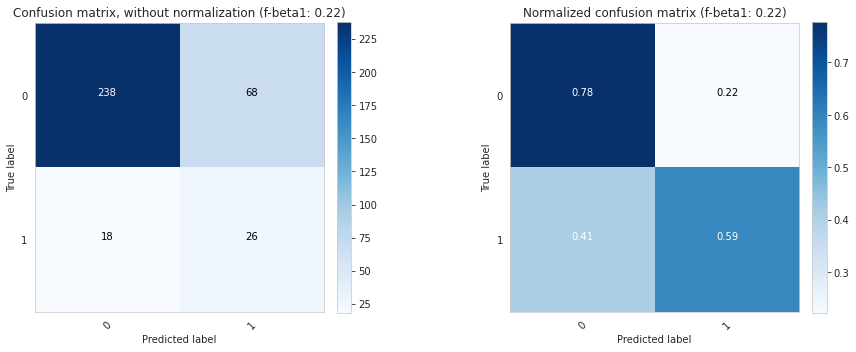

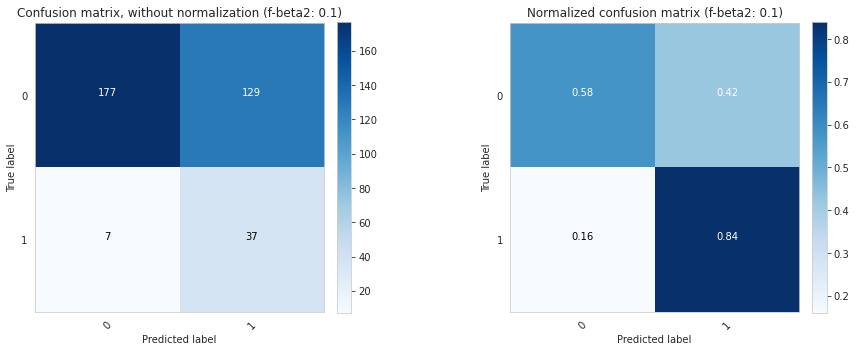



ROC Curve:


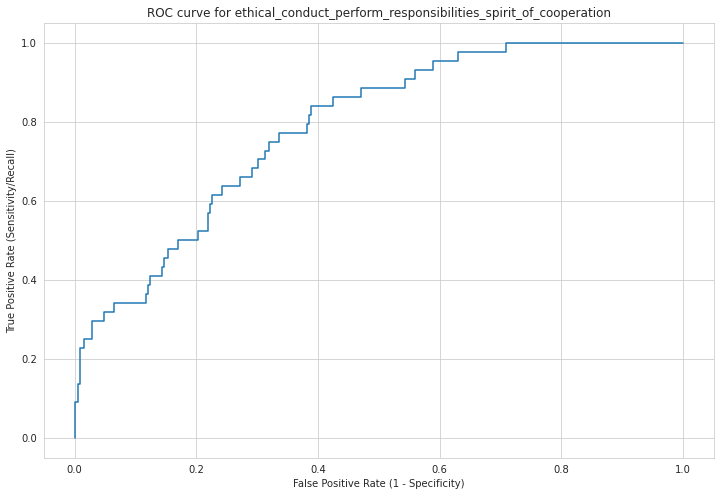

Predicted Probability Distribution:


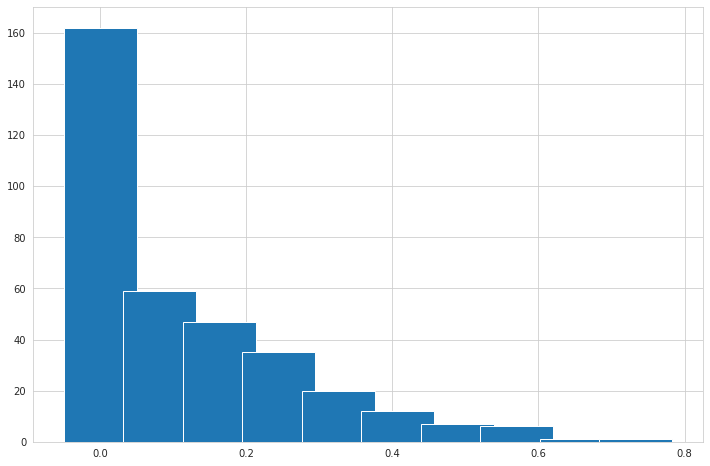



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9714285714285714
AUC Score:	0.8591176470588235

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9771428571428571	0.9571428571428572	0.9285714285714286	
Cohen's Kappa:	0.326923076923077	0.18856259659969077	0.21100090171325514	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.977               1.0                 0.9884              340                 
1                   1.0                 0.2                 0.3333              10                  
avg/total           0.9885              0.6                 0.6609              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9765              0.9794              0.978           

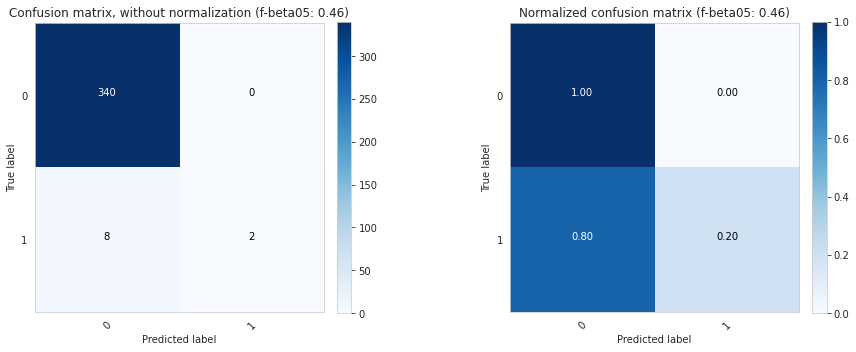

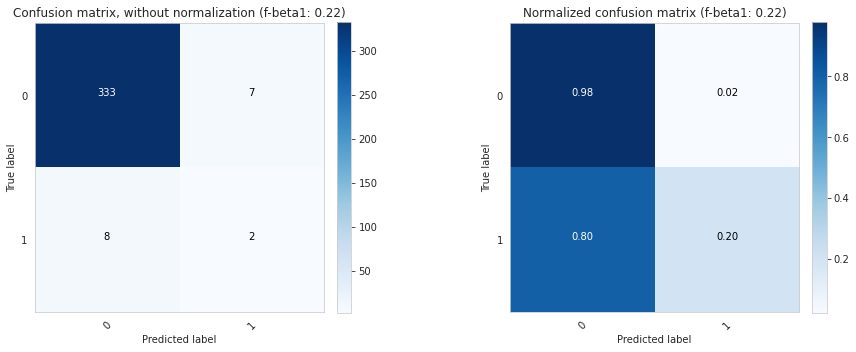

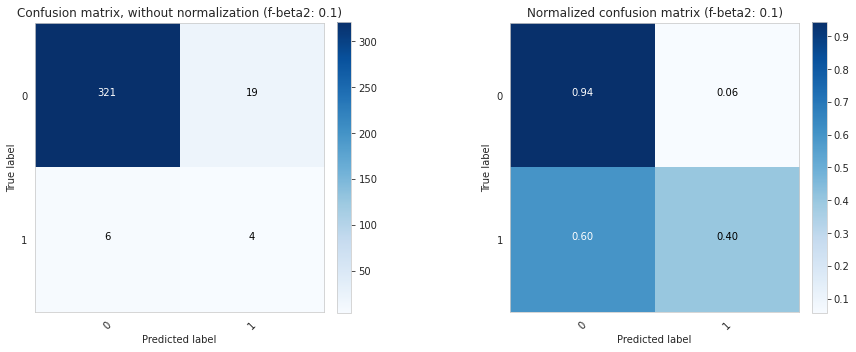



ROC Curve:


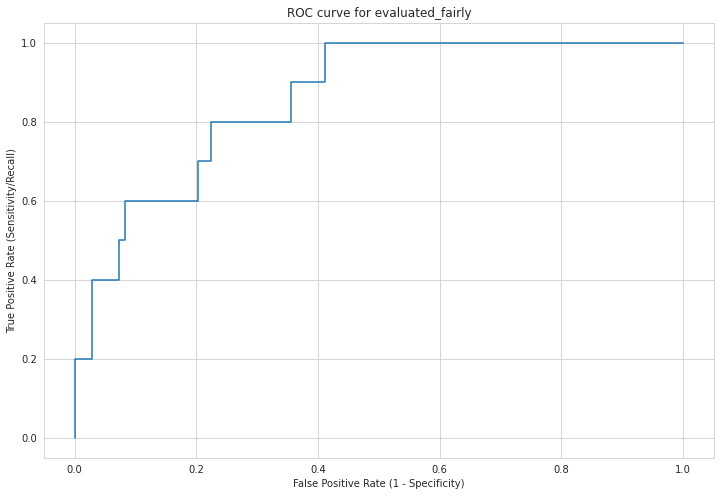

Predicted Probability Distribution:


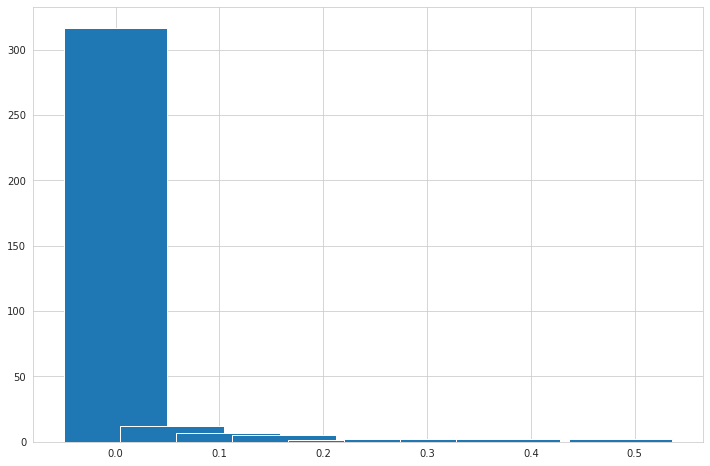



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.9028571428571428
AUC Score:	0.8379560685033507

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9028571428571428	0.88	0.82	
Cohen's Kappa:	0.2990103675777568	0.3952608194832976	0.3440233236151603	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9247              0.9715              0.9475              316                 
1                   0.5                 0.2647              0.3462              34                  
avg/total           0.7123              0.6181              0.6468              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9477              0.9177              0.9325              316            

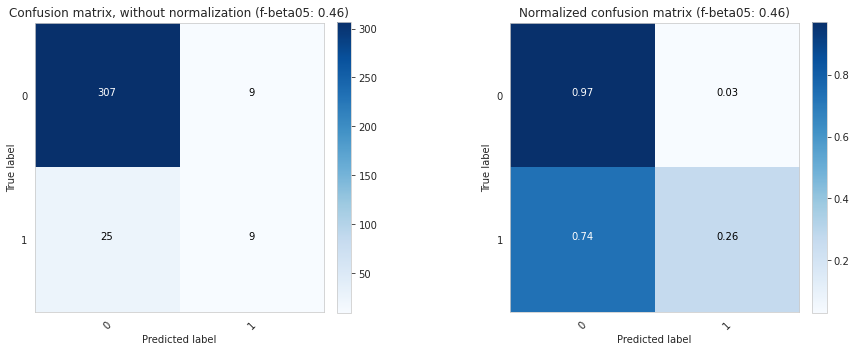

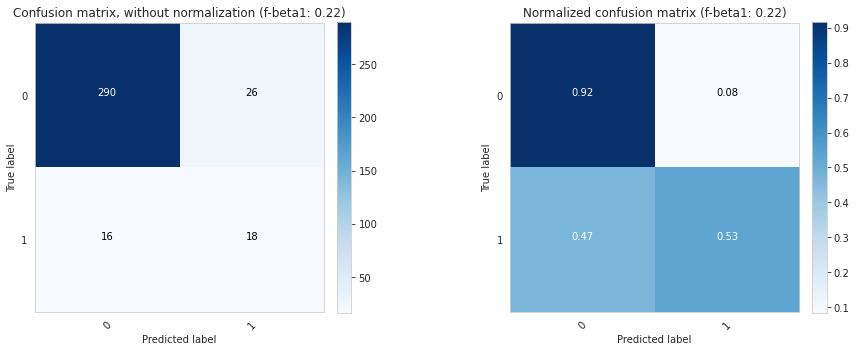

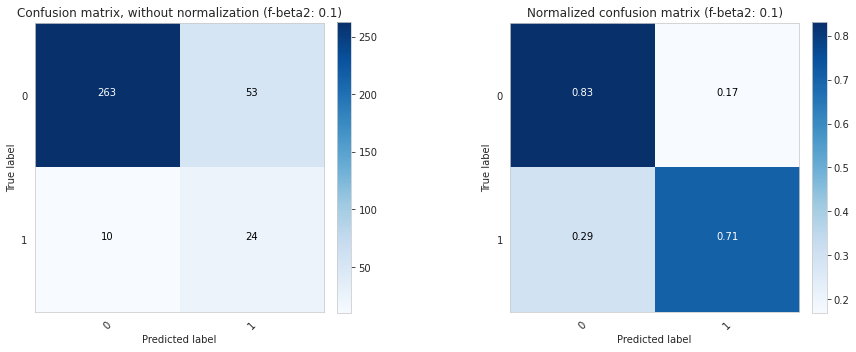



ROC Curve:


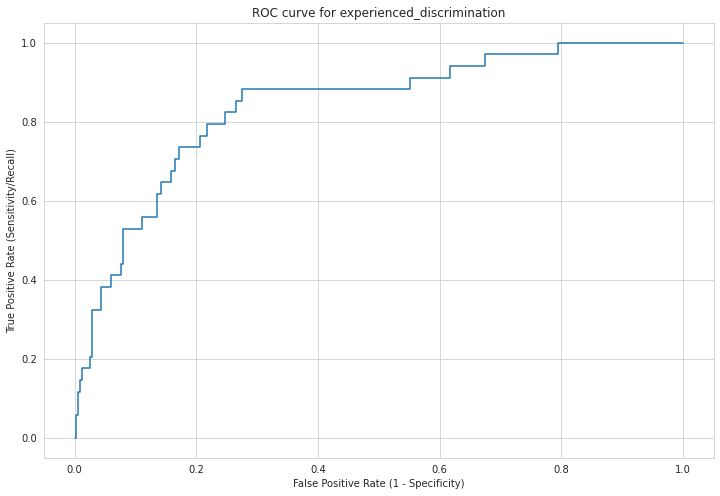

Predicted Probability Distribution:


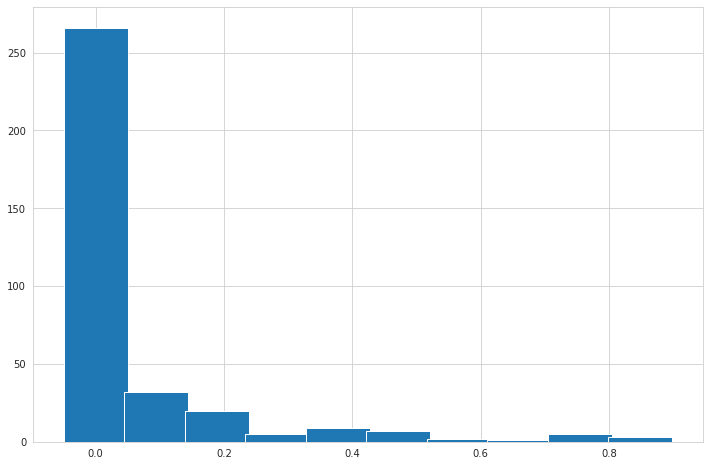



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.96
AUC Score:	0.8541666666666666

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9685714285714285	0.9542857142857143	0.9228571428571428	
Cohen's Kappa:	0.4086021505376345	0.40476190476190477	0.36500470366886173	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.971               0.997               0.9838              336                 
1                   0.8                 0.2857              0.4211              14                  
avg/total           0.8855              0.6414              0.7024              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9762              0.9762              0.9762            

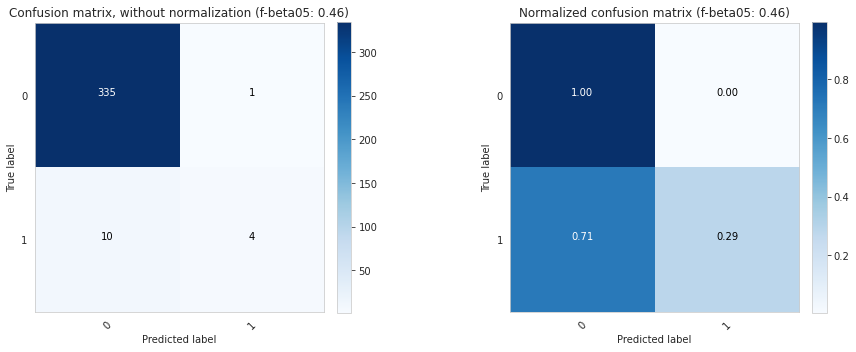

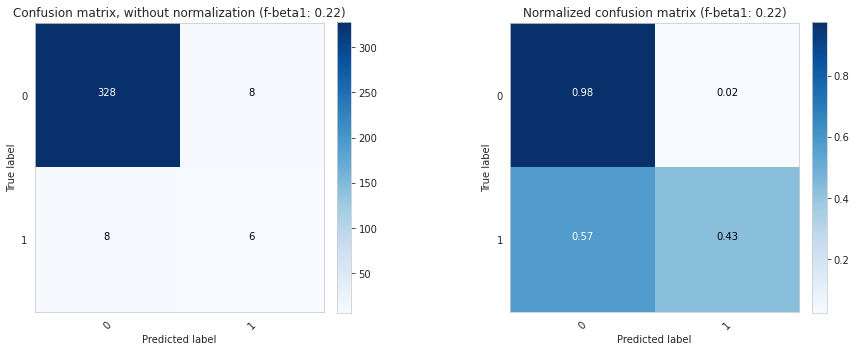

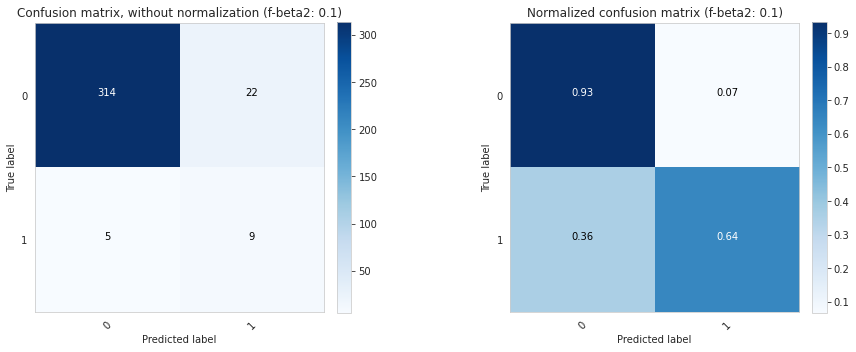



ROC Curve:


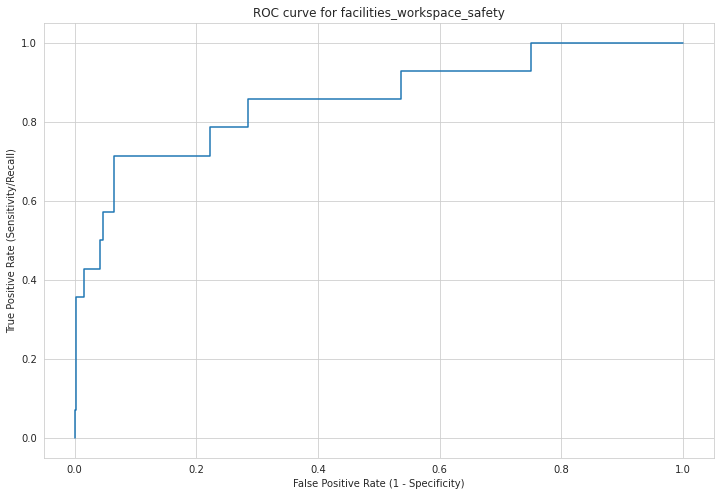

Predicted Probability Distribution:


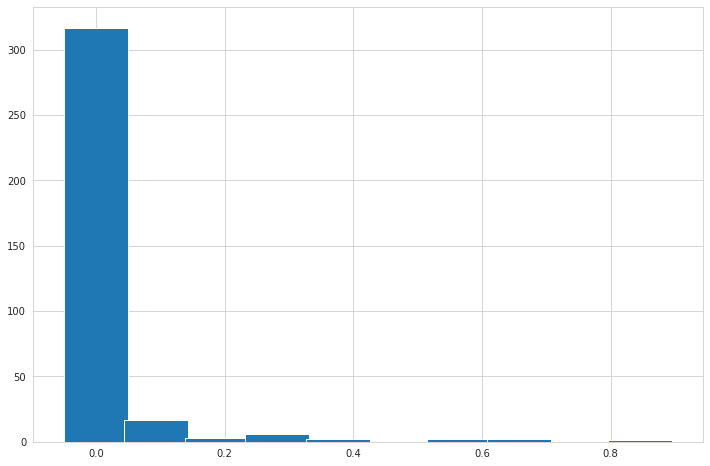



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.8857142857142857
AUC Score:	0.8167741935483871

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.8742857142857143	0.8428571428571429	0.7771428571428571	
Cohen's Kappa:	0.3197879858657243	0.3200282585658778	0.29711637487126663	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9182              0.9419              0.9299              310                 
1                   0.4375              0.35                0.3889              40                  
avg/total           0.6779              0.646               0.6594              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9293              0.8903              0.909

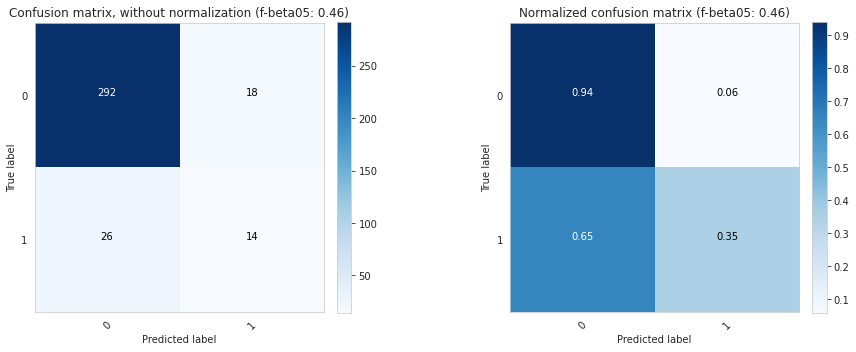

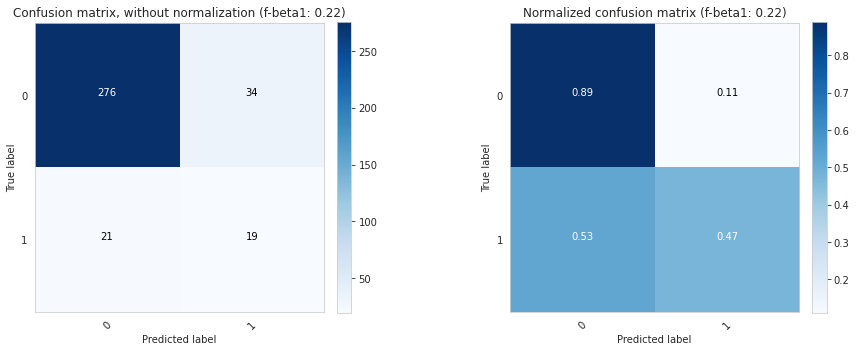

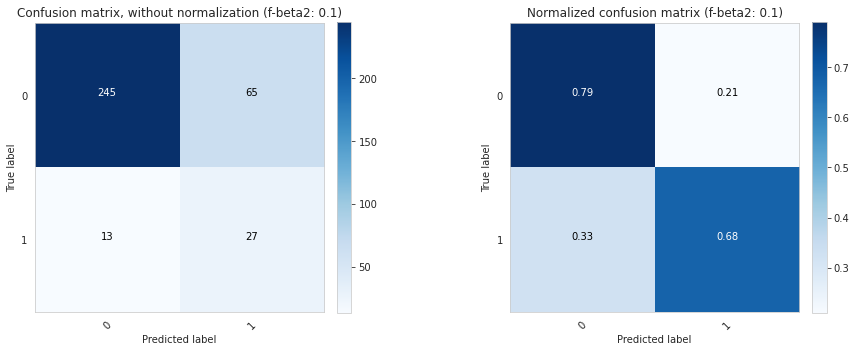



ROC Curve:


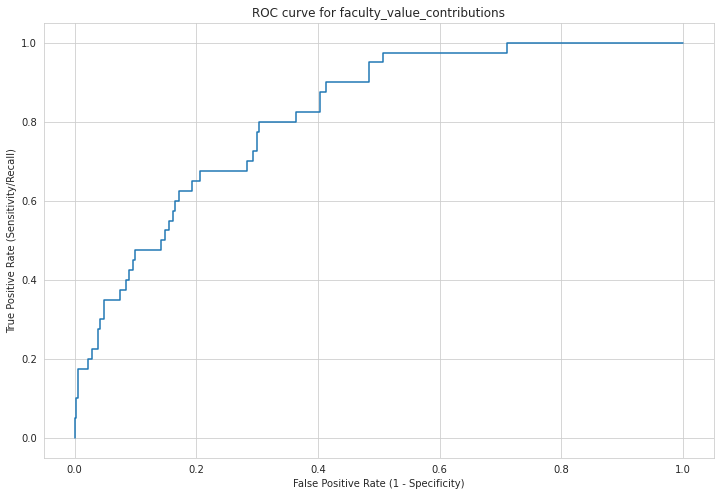

Predicted Probability Distribution:


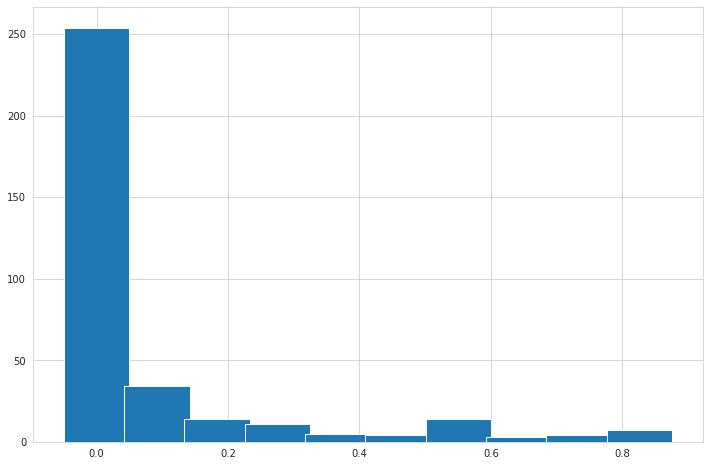



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9685714285714285
AUC Score:	0.8664521319388575

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9657142857142857	0.9514285714285714	0.9257142857142857	
Cohen's Kappa:	0.13115432354158052	0.16549789621318367	0.24481327800829877	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9712              0.9941              0.9825              339                 
1                   0.3333              0.0909              0.1429              11                  
avg/total           0.6523              0.5425              0.5627              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9735              0.9764              0.975       

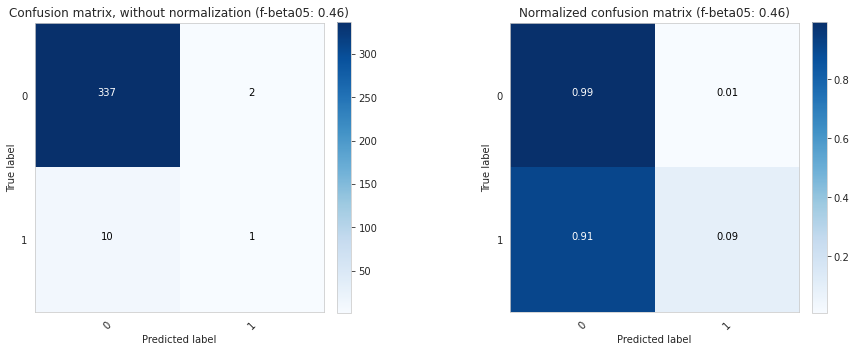

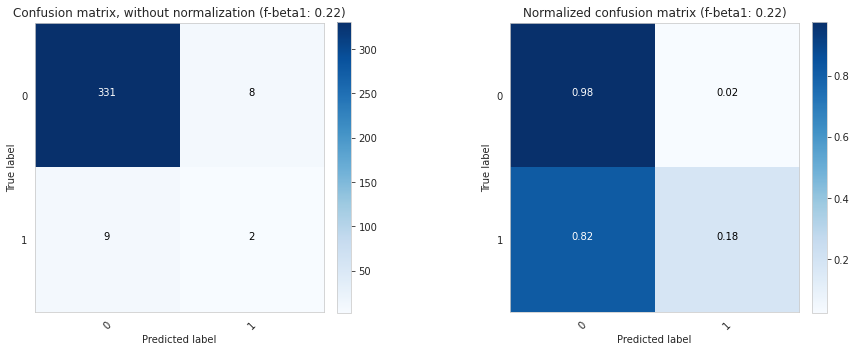

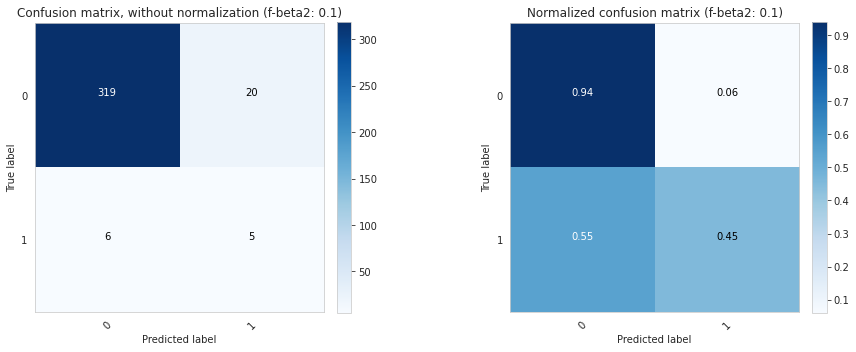



ROC Curve:


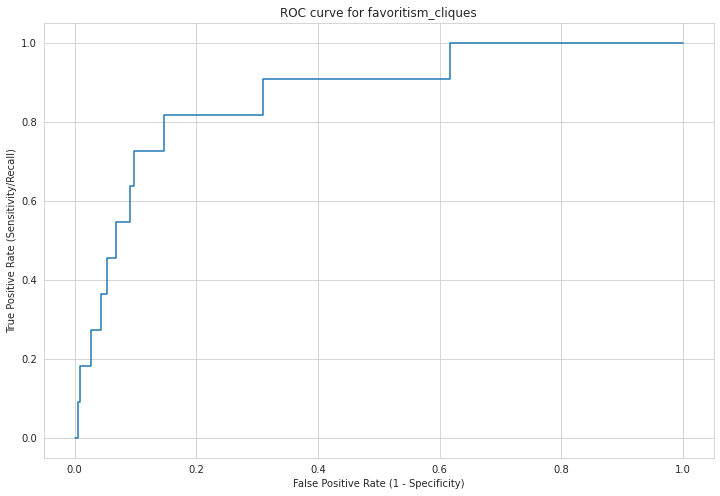

Predicted Probability Distribution:


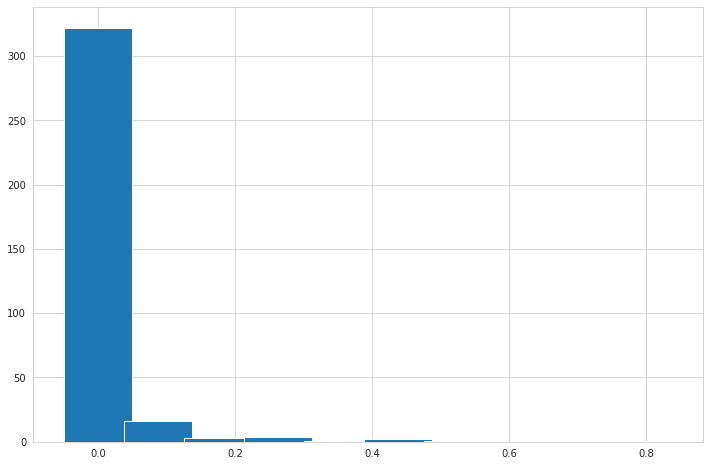



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.8771428571428571
AUC Score:	0.860768123626998

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9085714285714286	0.86	0.7942857142857143	
Cohen's Kappa:	0.4949950401298584	0.43514919965746657	0.3881416015150779	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9257              0.9739              0.9492              307                 
1                   0.7037              0.4419              0.5429              43                  
avg/total           0.8147              0.7079              0.746               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9418              0.8958              0.9182

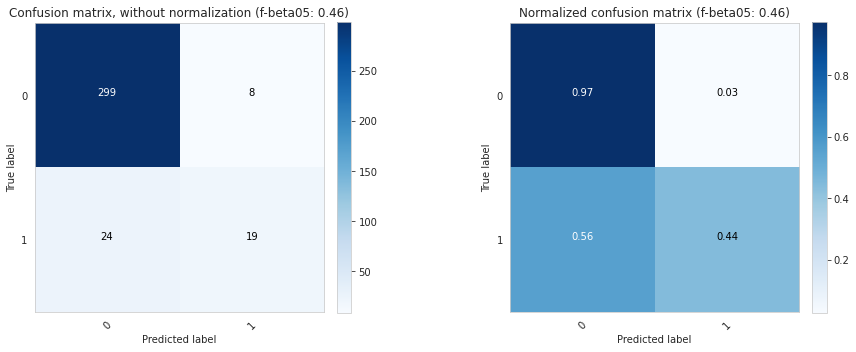

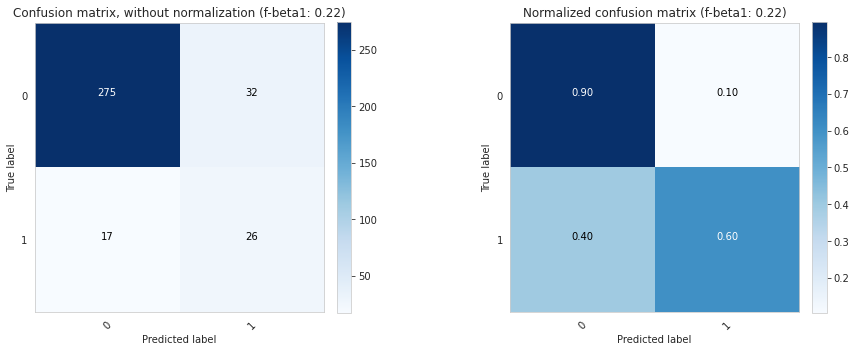

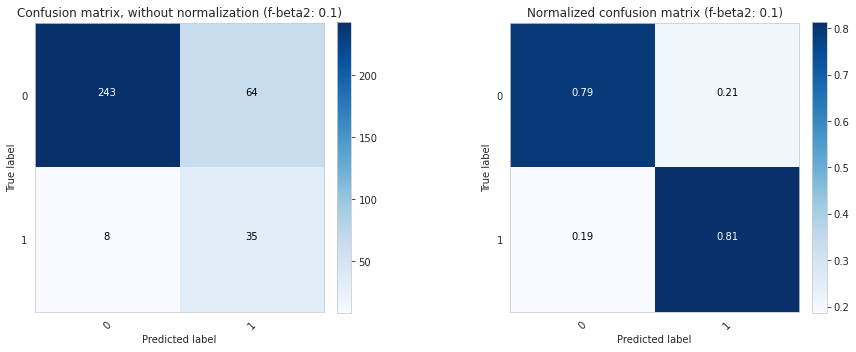



ROC Curve:


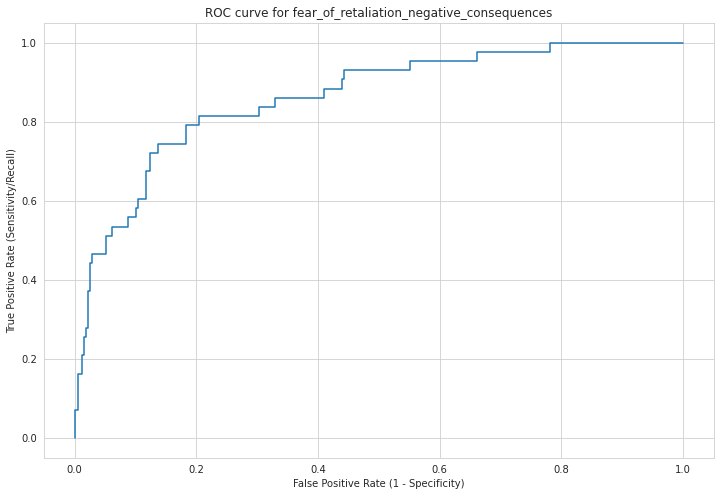

Predicted Probability Distribution:


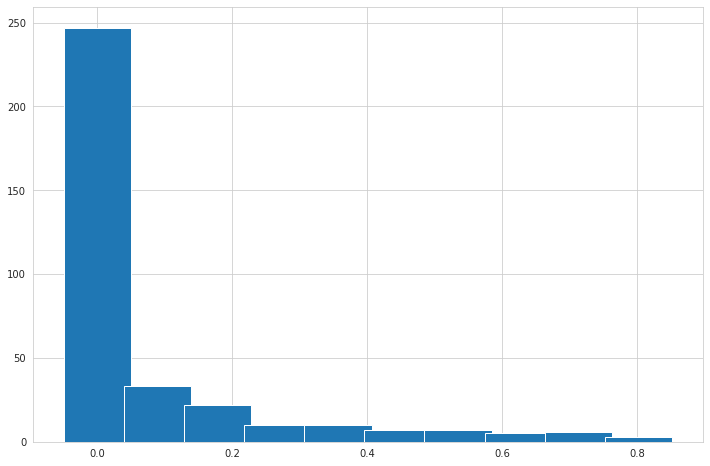



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8971428571428571
AUC Score:	0.7973283793347488

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9	0.8485714285714285	0.7314285714285714	
Cohen's Kappa:	0.2695289206917113	0.30726715960863393	0.19669889637659932	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9164              0.9777              0.9461              314                 
1                   0.5333              0.2222              0.3137              36                  
avg/total           0.7249              0.6                 0.6299              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9365              0.8917              0.9135              3

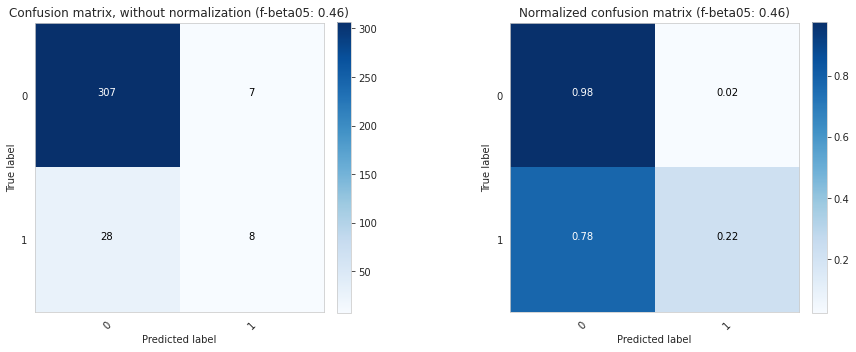

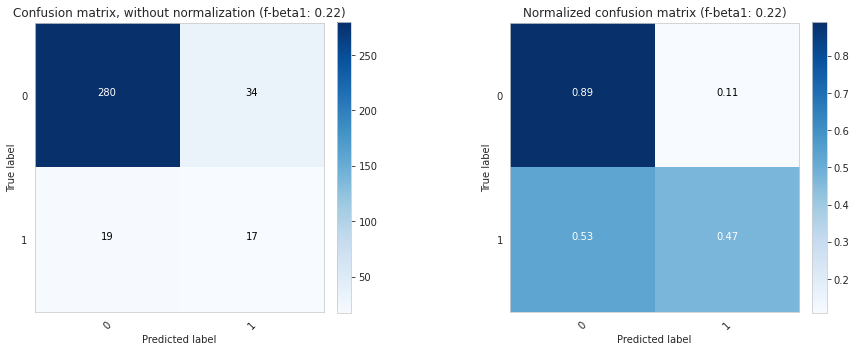

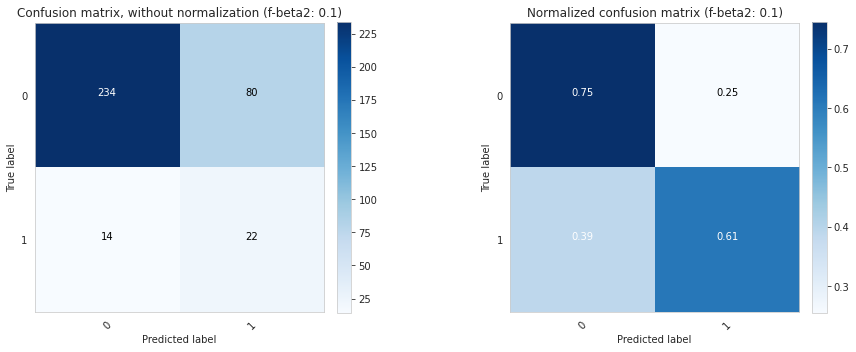



ROC Curve:


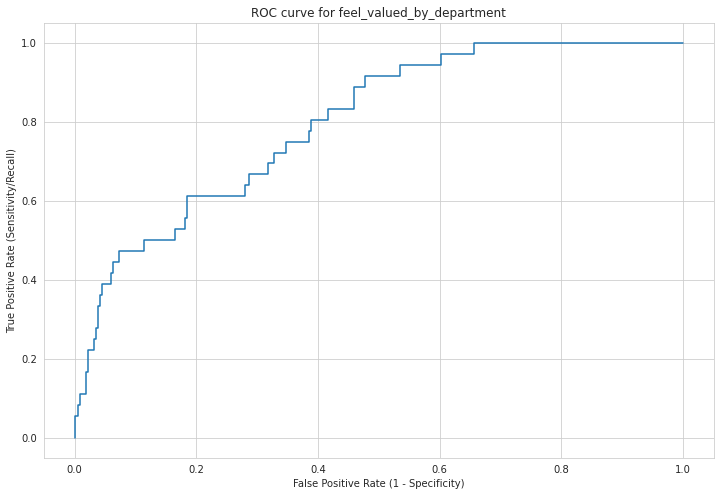

Predicted Probability Distribution:


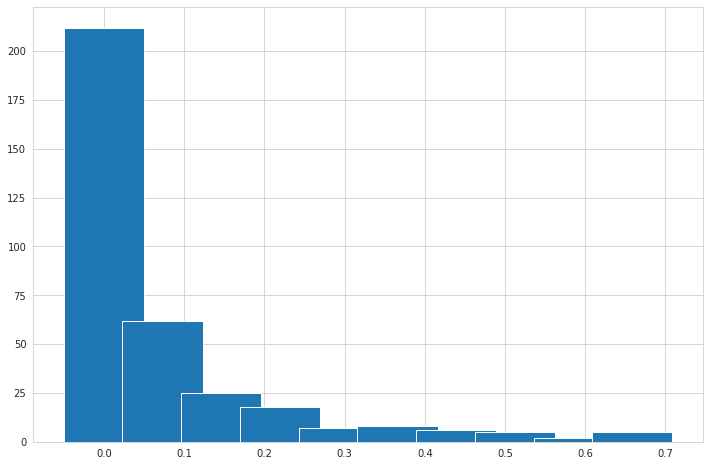



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.9628571428571429
AUC Score:	0.9155443962565625

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9657142857142857	0.96	0.9485714285714286	
Cohen's Kappa:	0.4823761400049297	0.4407669481853458	0.41154492807771337	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9794              0.9852              0.9822              337                 
1                   0.5455              0.4615              0.5                 13                  
avg/total           0.7624              0.7234              0.7411              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9792              0.9792              0.9792           

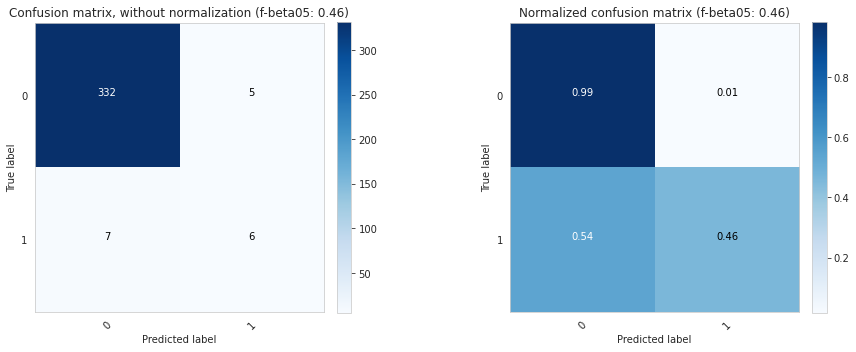

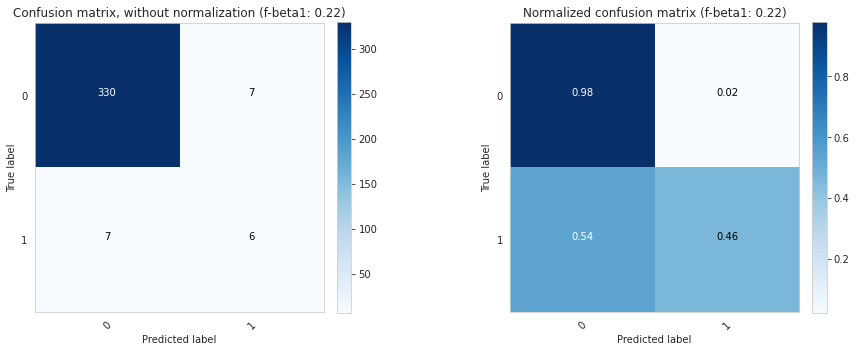

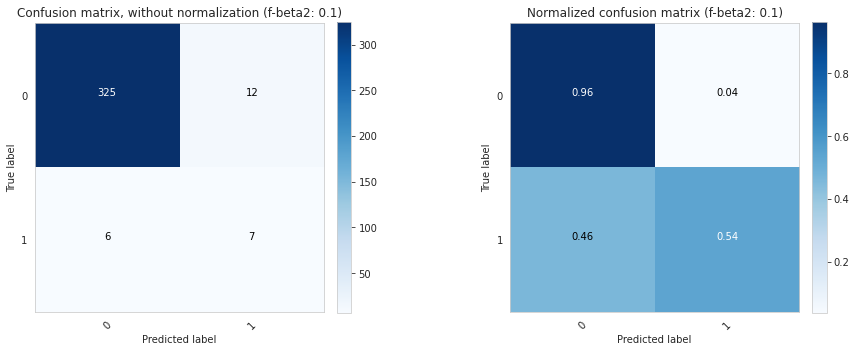



ROC Curve:


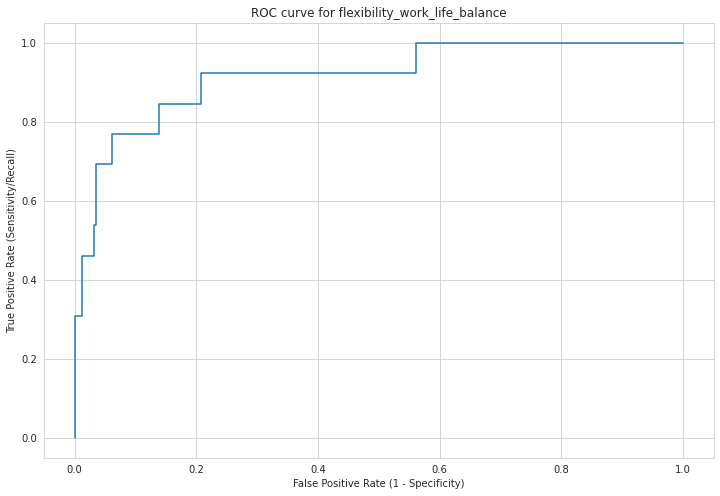

Predicted Probability Distribution:


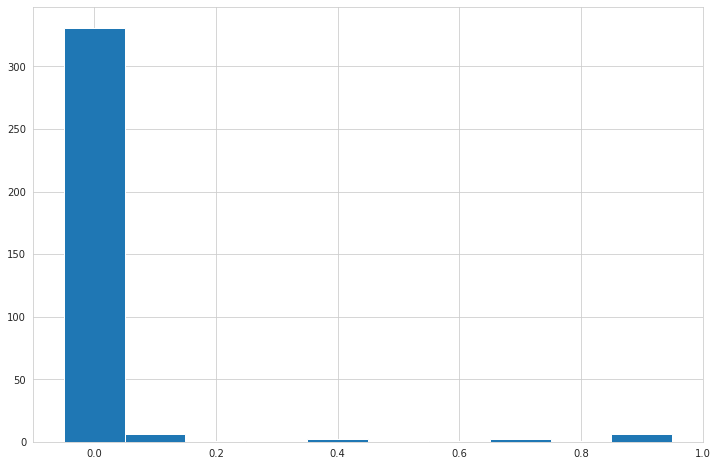



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.98
AUC Score:	0.7696793002915452

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.98	0.9771428571428571	0.9514285714285714	
Cohen's Kappa:	0.0	0.19028340080971662	0.23971377459749554	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.98                1.0                 0.9899              343                 
1                   0.0                 0.0                 0.0                 7                   
avg/total           0.49                0.5                 0.4949              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9827              0.9942              0.9884              343                 
1              

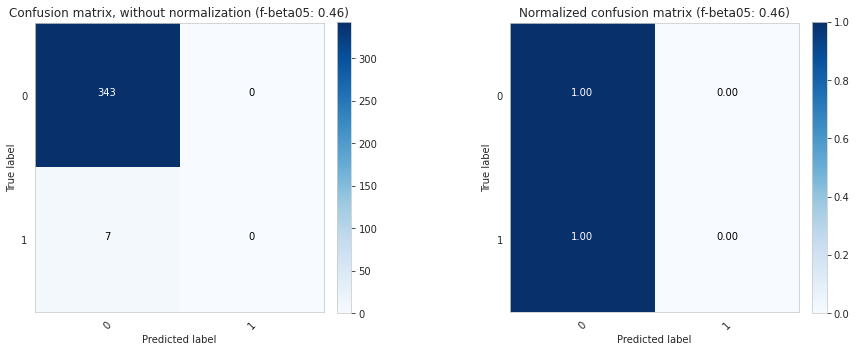

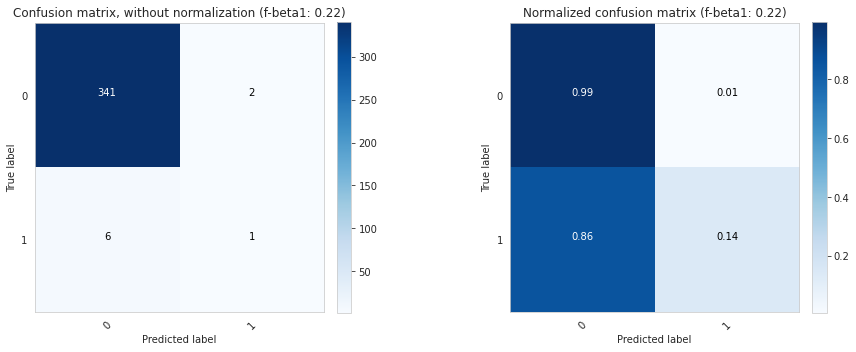

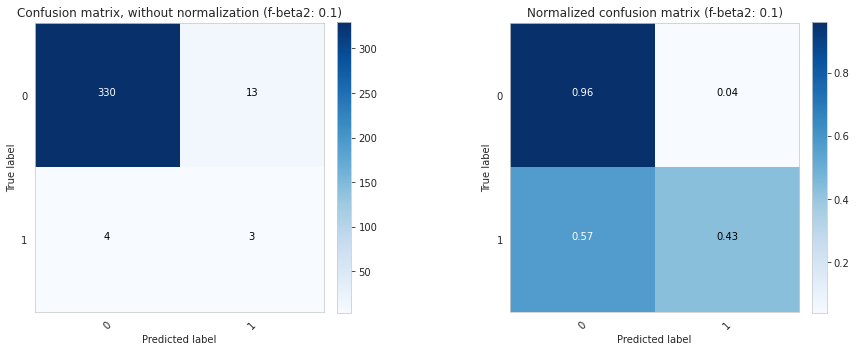



ROC Curve:


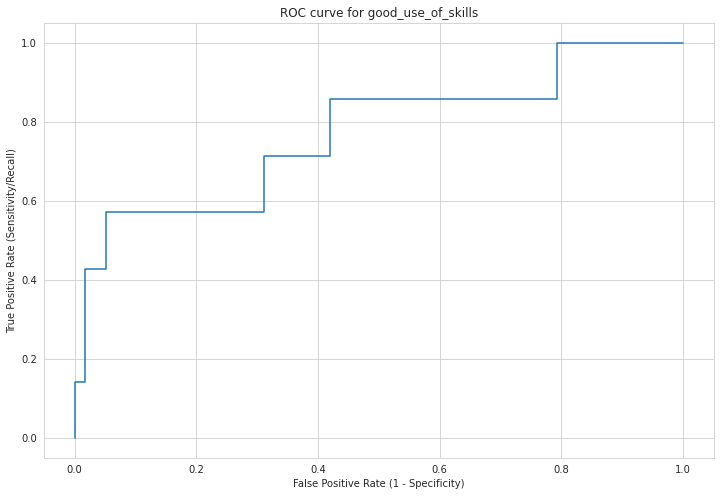

Predicted Probability Distribution:


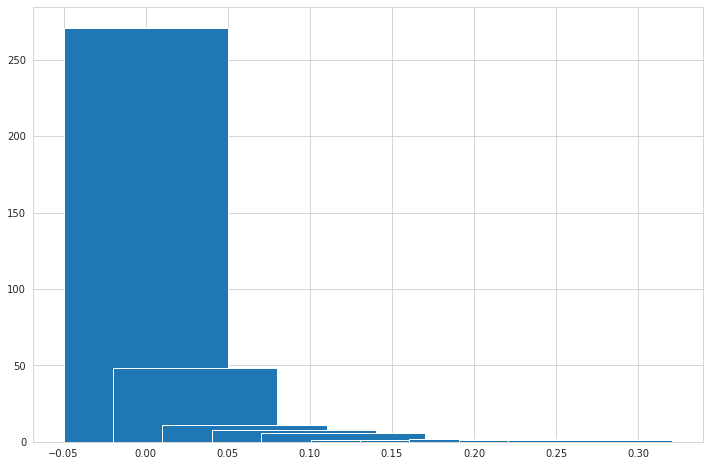



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.9771428571428571
AUC Score:	0.9649122807017545

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9857142857142858	0.9742857142857143	0.9657142857142857	
Cohen's Kappa:	0.6085011185682327	0.4574578022735101	0.3830787309048179	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9884              0.9971              0.9927              342                 
1                   0.8                 0.5                 0.6154              8                   
avg/total           0.8942              0.7485              0.8041              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9883              0.9854              0.9868       

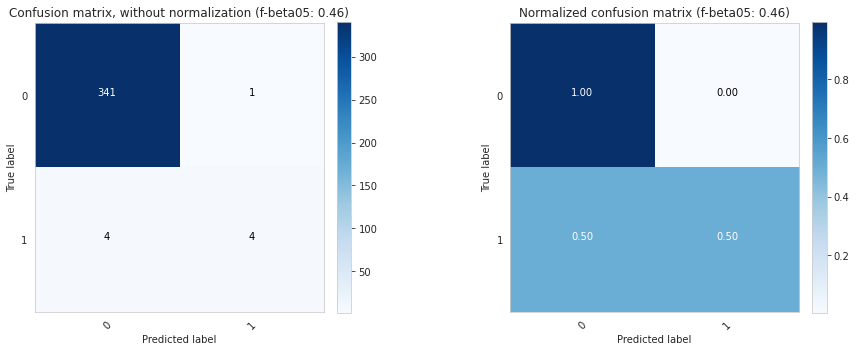

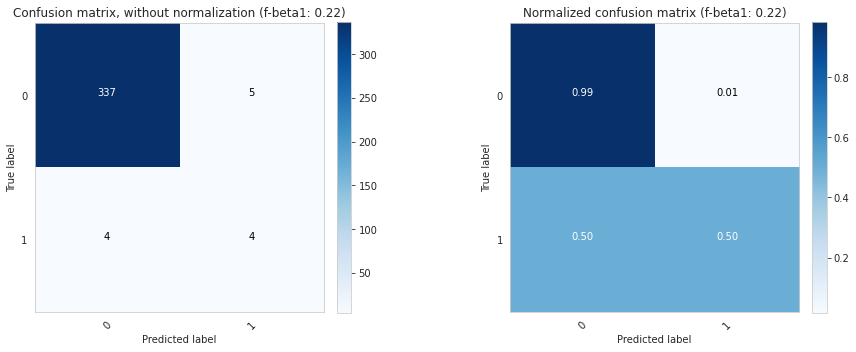

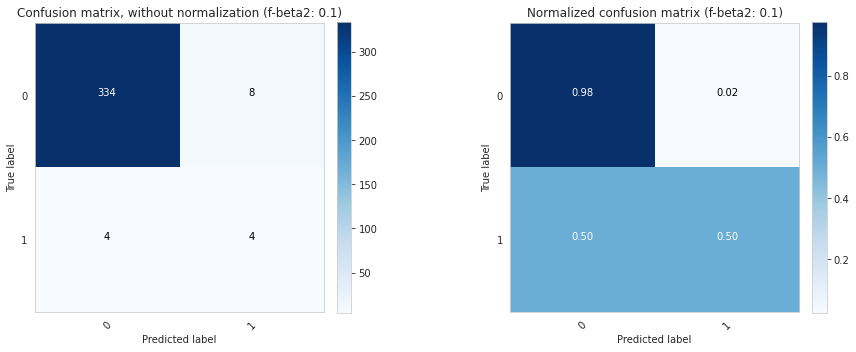



ROC Curve:


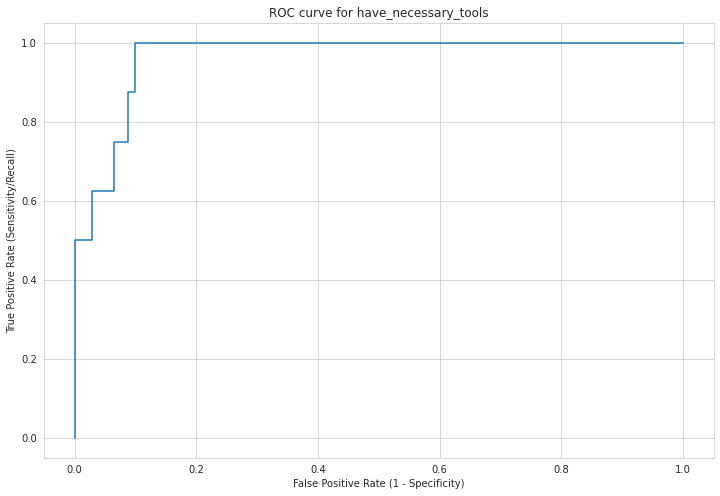

Predicted Probability Distribution:


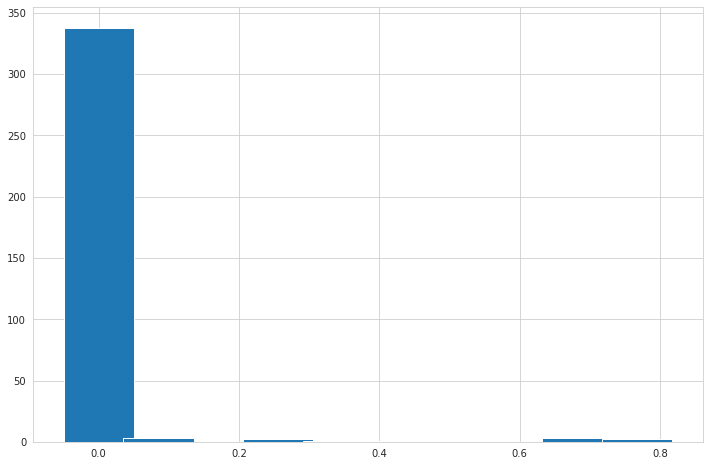



----------------------------------------------------------------------------------------------------


HAVE_VOICE_WITHIN_MY_INSTITUTION_VALUED_MEMBER_OF_MY_INSTITUTION

Null Accuracy:	0.9228571428571428
AUC Score:	0.8218094255245957

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.92	0.9057142857142857	0.8628571428571429	
Cohen's Kappa:	0.14945321992709604	0.2764064653552186	0.2424925601947877	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.93                0.9876              0.958               323                 
1                   0.4286              0.1111              0.1765              27                  
avg/total           0.6793              0.5494              0.5672              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9421              0.

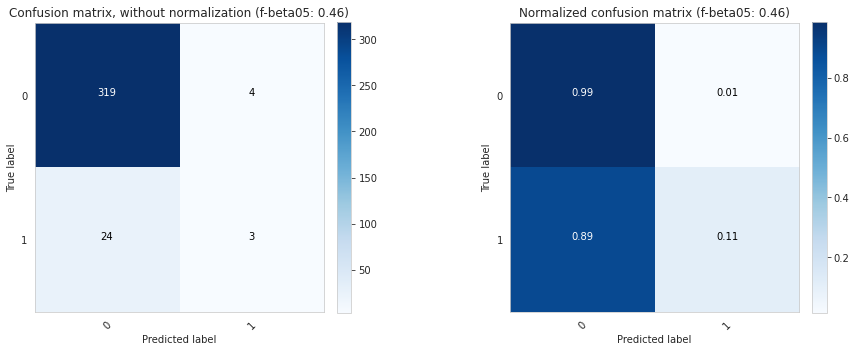

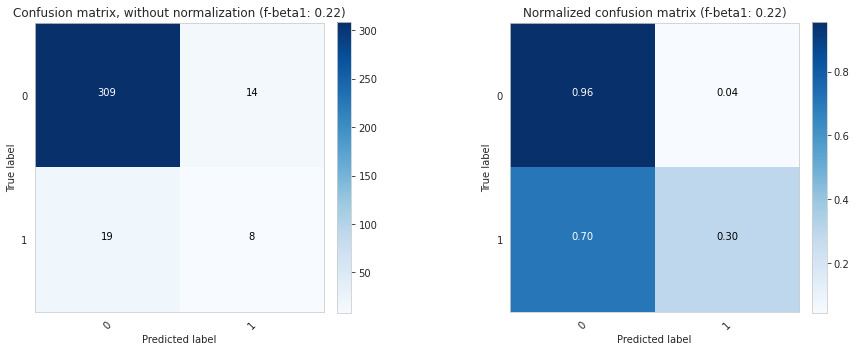

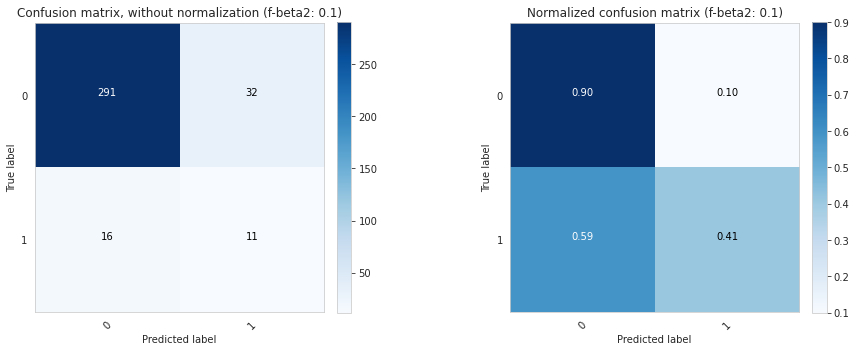



ROC Curve:


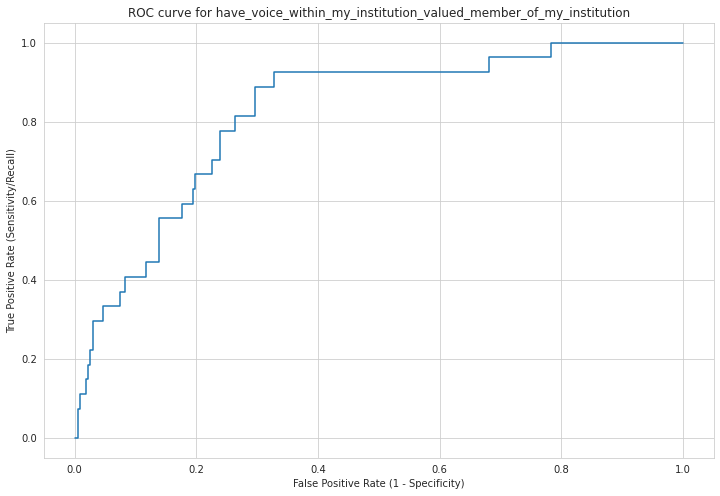

Predicted Probability Distribution:


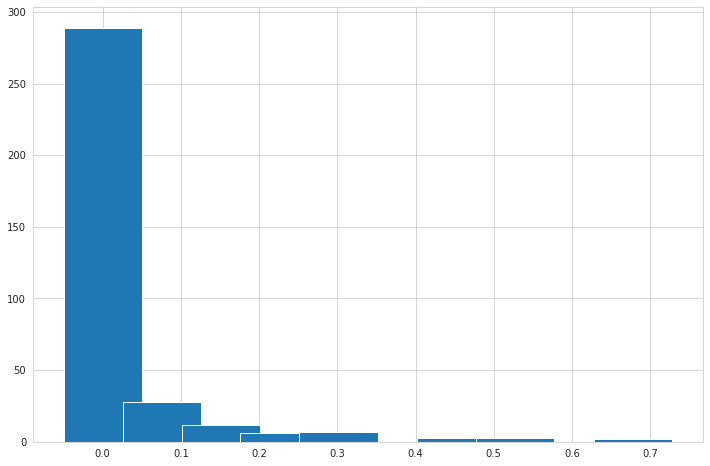



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.9571428571428572
AUC Score:	0.9317412935323384

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.96	0.9314285714285714	0.8714285714285714	
Cohen's Kappa:	0.4412770809578107	0.421885753613214	0.3009320905459387	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9735              0.9851              0.9792              335                 
1                   0.5455              0.4                 0.4615              15                  
avg/total           0.7595              0.6925              0.7204              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9844              0.9433              0.9634              

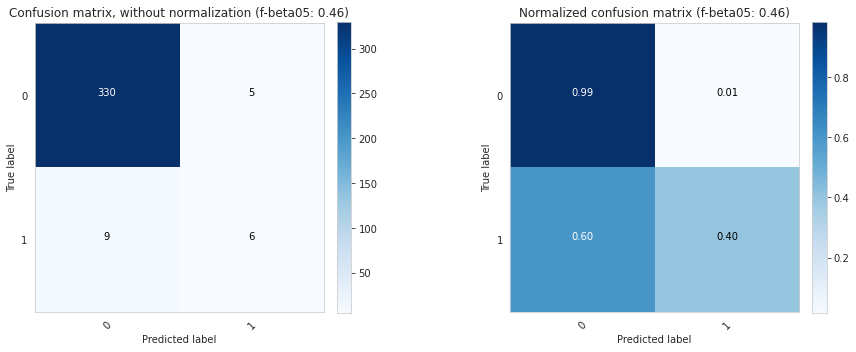

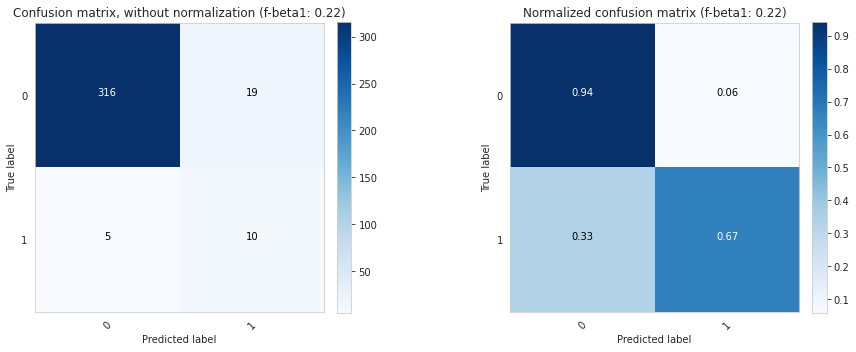

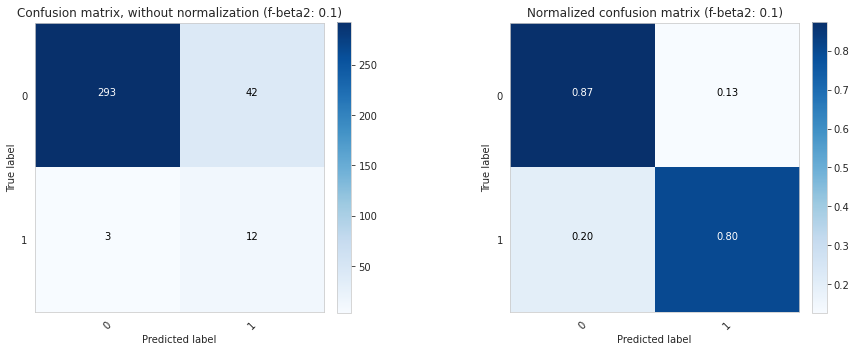



ROC Curve:


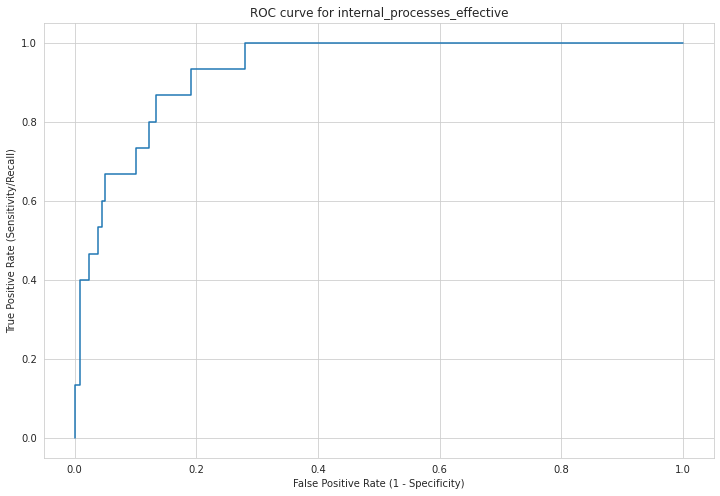

Predicted Probability Distribution:


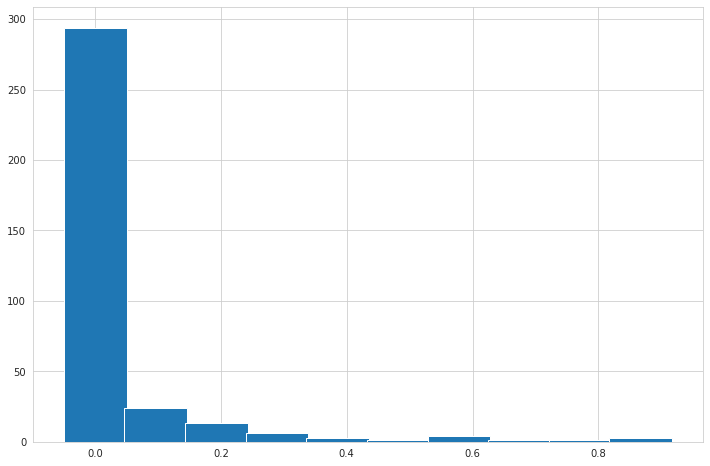



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9771428571428571
AUC Score:	0.9923245614035088

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.98	0.9771428571428571	0.9771428571428571	
Cohen's Kappa:	0.578022735101619	0.5887191539365453	0.656188605108055	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9912              0.9883              0.9898              342                 
1                   0.5556              0.625               0.5882              8                   
avg/total           0.7734              0.8067              0.789               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9941              0.9825              0.9882              342    

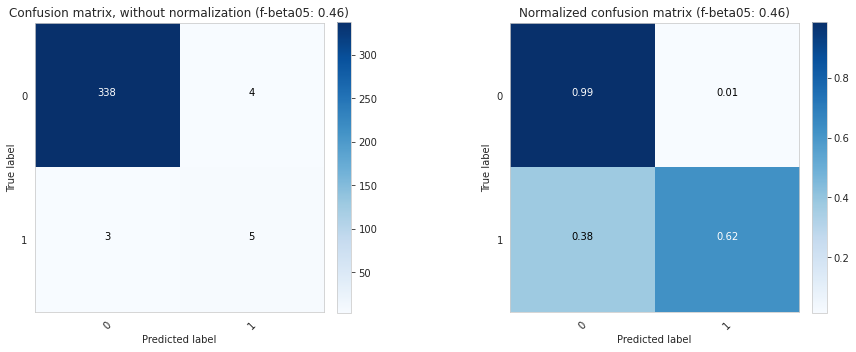

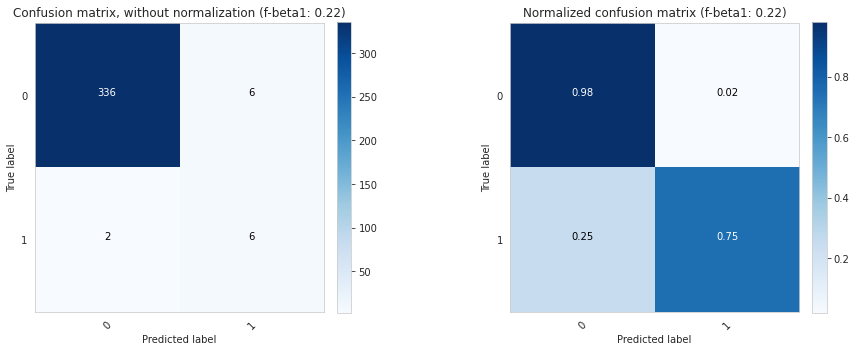

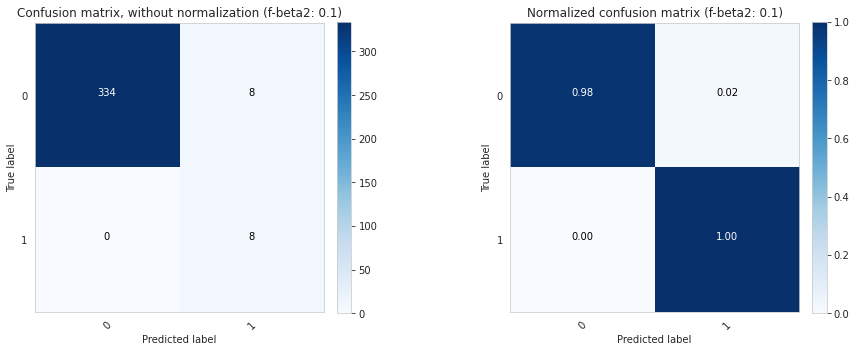



ROC Curve:


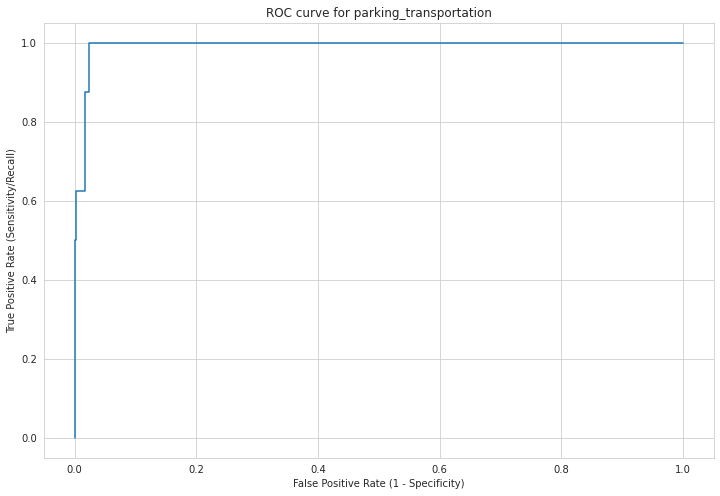

Predicted Probability Distribution:


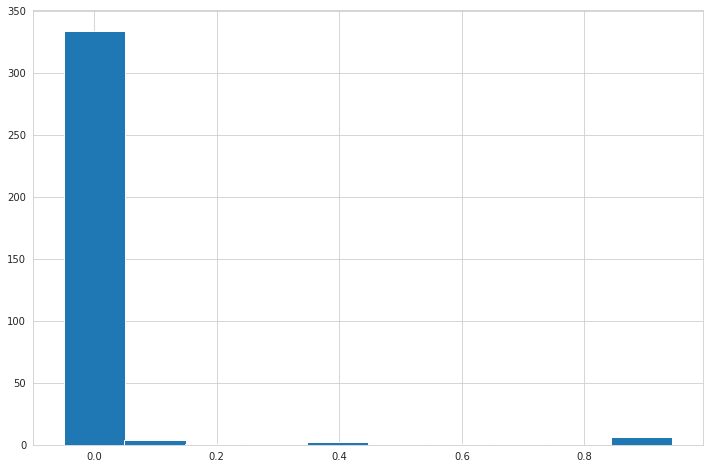



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.9142857142857143
AUC Score:	0.9091666666666667

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.9171428571428571	0.8571428571428571	0.8171428571428572	
Cohen's Kappa:	0.47922011287839916	0.3855337078651685	0.3679458239277653	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9561              0.9531              0.9546              320                 
1                   0.5161              0.5333              0.5246              30                  
avg/total           0.7361              0.7432              0.7396              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9688              0.8719              0.9178              32

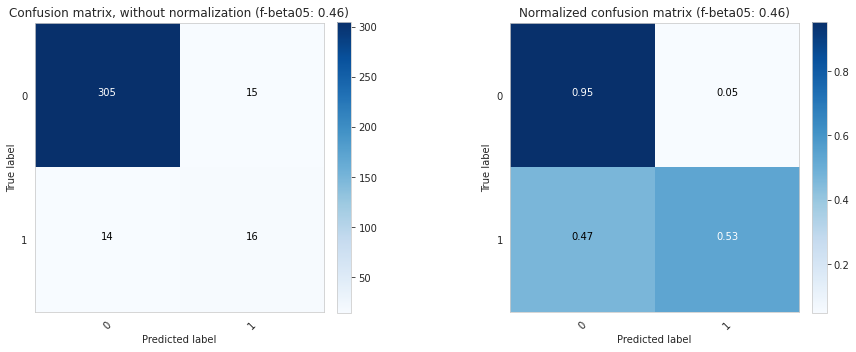

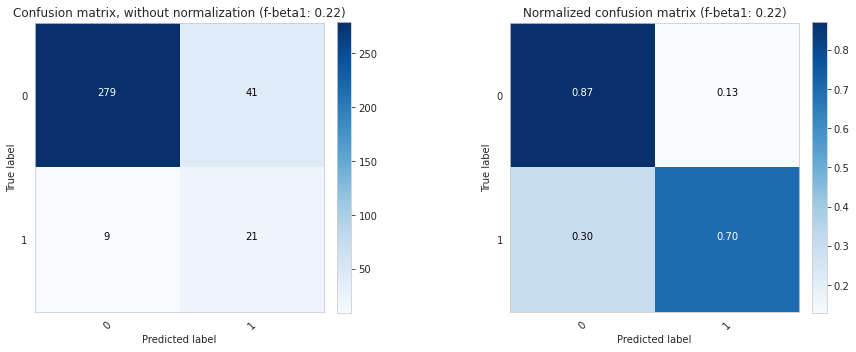

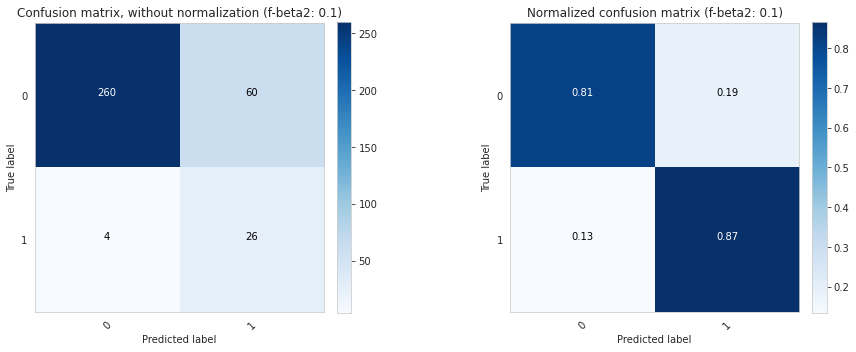



ROC Curve:


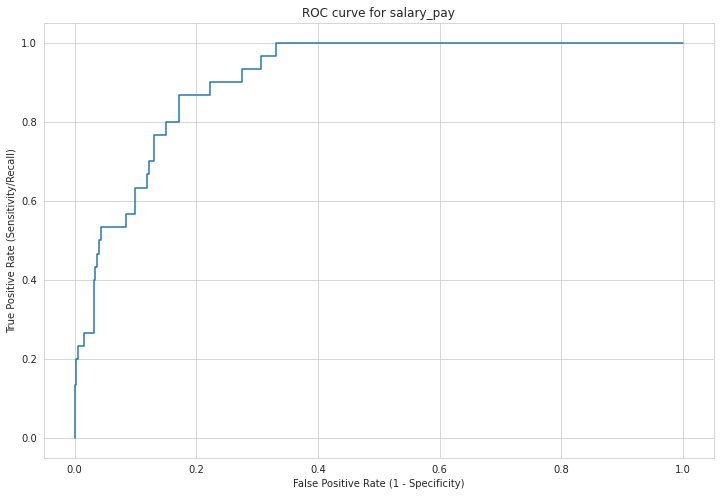

Predicted Probability Distribution:


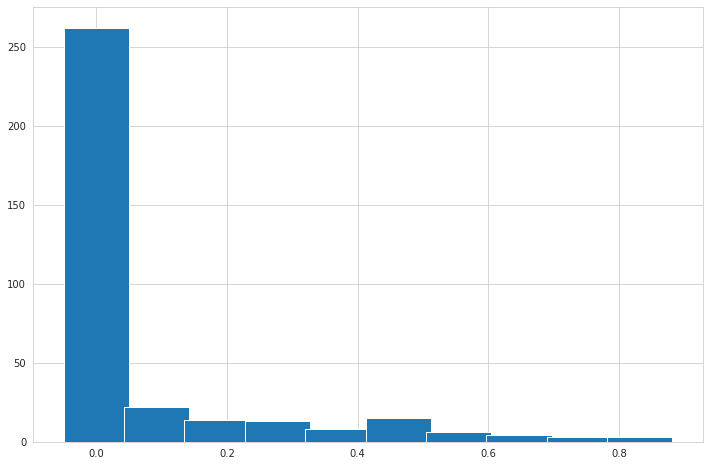



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.9228571428571428
AUC Score:	0.7845430569888774

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.8828571428571429	0.8228571428571428	0.7428571428571429	
Cohen's Kappa:	0.21713038734315337	0.19372817121200858	0.17457156333525492	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9406              0.9319              0.9362              323                 
1                   0.2667              0.2963              0.2807              27                  
avg/total           0.6036              0.6141              0.6085              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9485              0.8545            

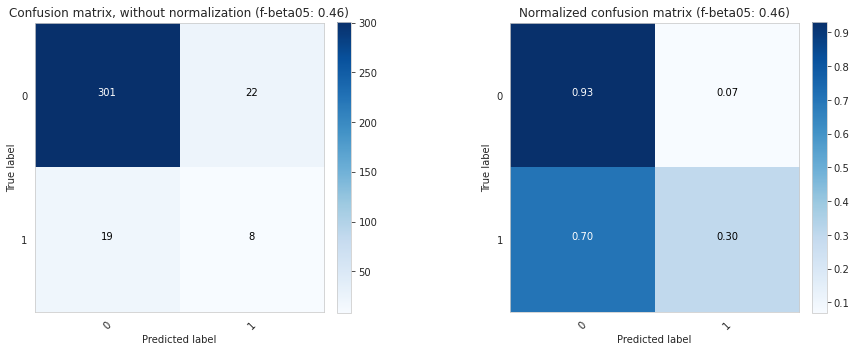

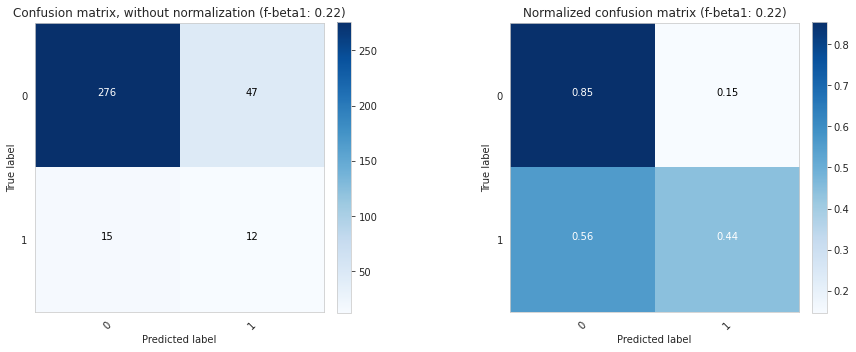

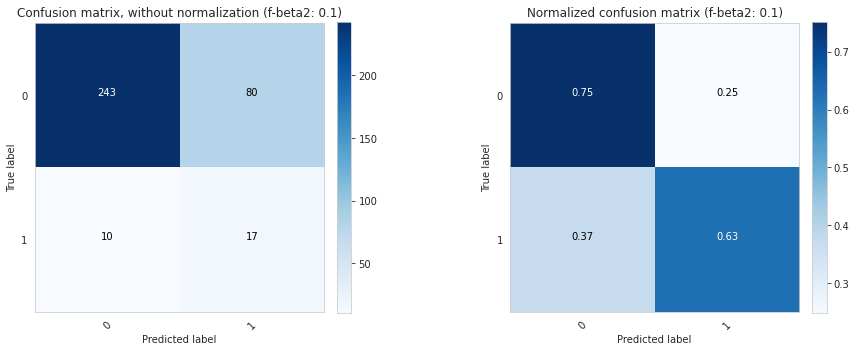



ROC Curve:


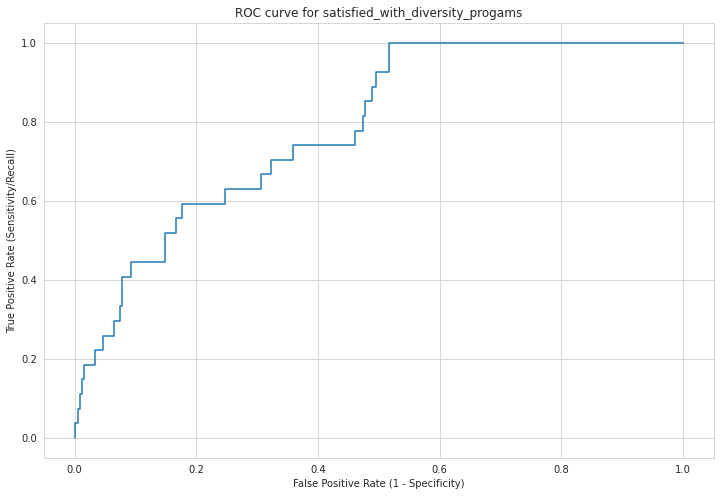

Predicted Probability Distribution:


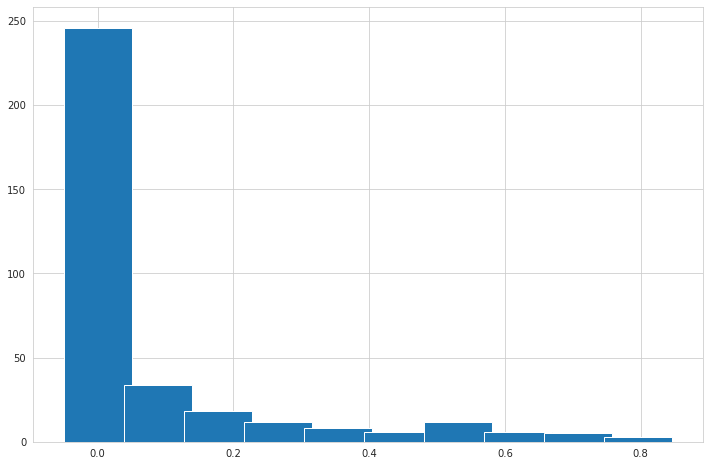



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8914285714285715
AUC Score:	0.8431174089068827

		f-beta05(0.46)		f-beta1(0.22)		f-beta2(0.1)
Accuracy:	0.8828571428571429	0.8485714285714285	0.7742857142857142	
Cohen's Kappa:	0.24687729610580456	0.3704608701554333	0.3340879533741149	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9119              0.9615              0.936               312                 
1                   0.4286              0.2368              0.3051              38                  
avg/total           0.6702              0.5992              0.6206              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.945               0.8814

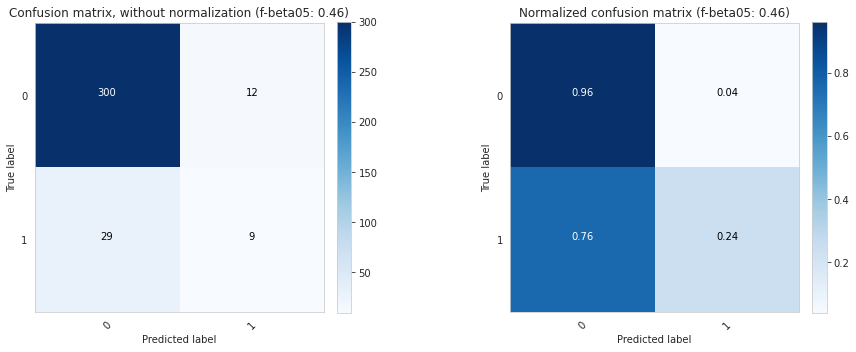

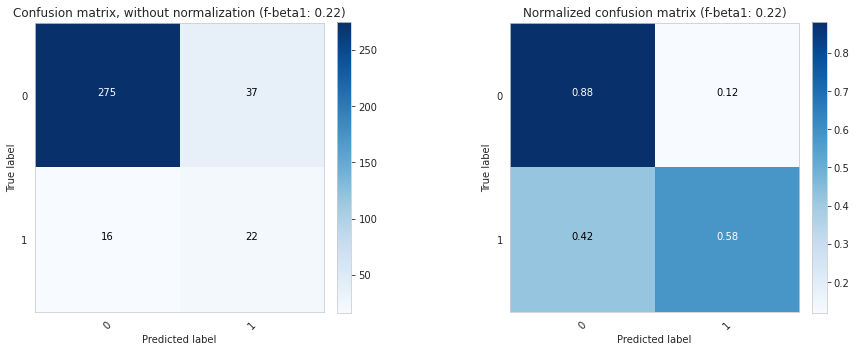

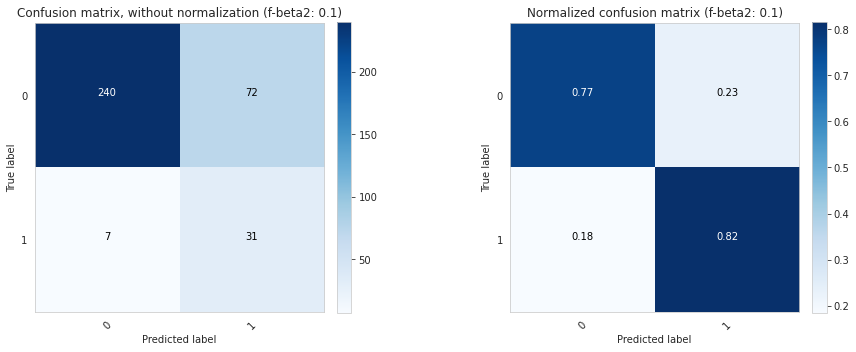



ROC Curve:


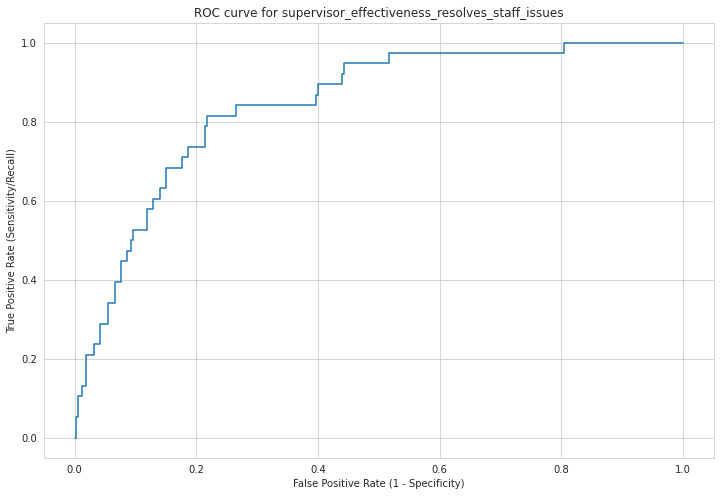

Predicted Probability Distribution:


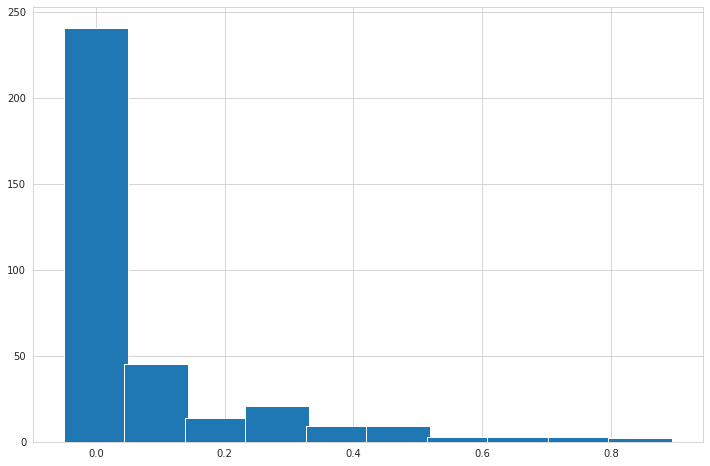



----------------------------------------------------------------------------------------------------




In [107]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multilabel'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

learn_fwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'fwd_export_clas{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'bwd_export_clas{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
# learn_fwd.loss_func = learn_fwd.loss_func.to('cuda:1')
# learn_bwd.loss_func = learn_fwd.loss_func.to('cuda:1')

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

# probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final = (probs_fwd + probs_bwd) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_fwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_fwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_fwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_fwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_bwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_bwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_bwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_bwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_final, lbl_fwd)
threshold_f1 = f1.opt_th(probs_final, lbl_fwd)
threshold_f2 = f2.opt_th(probs_final, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_final, lbl_fwd, sigmoid=False)}')

In [ ]:
final_valid_loss = (loss_fwd.mean() + loss_bwd.mean()) / 2
final_valid_loss

In [ ]:
# save this information to be added to inference returned data
model_results = {
    'threshold_f05': threshold_f05,
    'threshold_f1': threshold_f1,
    'threshold_f2': threshold_f2,
    
    'val_acc_f05': val_acc_f05,
    'val_acc_f1': val_acc_f1,
    'val_acc_f2': val_acc_f2,
    'val_loss': final_valid_loss.item()
}

with open(STANDARD_THEME_SAW_PATH/'model_results.json', 'w') as f: json.dump(model_results, f)

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_SAW_LABELS)

In [ ]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_theme_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_theme_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_theme_results(backwards=True)

probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
final_df.AnswerText[final_df.Id == 589546].values

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [ ]:
%time 

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2